# HEALTH INSURANCE CROSS SELL

Insurance ALL Company is a financial corporation that offers direct reinsurance services, providing financial protection for individuals, families and small business. The objective is to build a model that predicts whether or not the company's customers would be interested in a new product: auto insurance.

This way, the sales team hopes to be able to prioritize the customers with the greatest interest in the new product and, thus, optimize the campaign by clients the customers most likely to make the purchase.

## INDEX

- **0.0. DATA COLLECTION**
- **1.0. DATA DESCRIPTION**
- **2.0. FEATURE ENGINEERING**
- **3.0. EXPLORATORY DATA ANALYSIS**
- **4.0. DATA PREPARATION**
- **5.0. FEATURE SELECTION**
- **6.0. MACHINE LEARNING MODELLING**
- **7.0. PERFORMANCE METRICS**
- **8.0. DEPLOY MODEL TO PRODUCTION**

# 0.0. DATA COLLECTION
## 0.1 Imports

In [5]:
# Connection to Database
import psycopg2              as pg
import pandas.io.sql         as psql

#data manipulation
import pandas                as pd
import numpy                 as np

#data visualization
import matplotlib.pyplot     as plt
import seaborn               as sns
from matplotlib              import gridspec
import scikitplot            as skplt

#sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler, RobustScaler
from sklearn.ensemble        import ExtraTreesClassifier, RandomForestClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn                 import metrics as m
from sklearn                 import neighbors as nh

from IPython.display         import Image
from IPython.core.display    import HTML
from boruta                  import BorutaPy
import warnings
import requests
import pickle
warnings.filterwarnings('ignore')

## 0.2. Helper Functions

In [6]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
jupyter_settings()  

def score_metrics(y_true,yhat):
    #accuracy
    acc = m.accuracy_score(y_true,yhat)
    #precision
    pre = m.precision_score(y_true,yhat)
    #recall
    recall = m.recall_score(y_true,yhat)
    #f1-score
    f1 = m.f1_score(y_true,yhat)
    
    score_dict = {
                  "Accuracy": acc,
                  "Precision":pre,
                  "Recall":recall,
                  "F1-Score":f1}
    
    
    final_score = pd.DataFrame.from_dict(score_dict, orient = 'index').T
    
    return final_score


Populating the interactive namespace from numpy and matplotlib


In [7]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.3. SQL - connect and query

In [8]:
#credentials
database = {"database"}
host = {"host"}
port = {"port"}
user = {"user"}
password = {"password"}

In [ ]:
#engine to databse
conn = pg.connect(host = host,
           database = database,
           port = port, 
           user = user,
           password = password)

In [ ]:
#create cursor
cur = conn.cursor()

query_schema = """
    select nspname
    from pg_catalog.pg_namespace

"""

cur.execute(query_schema)

In [ ]:
record = cur.fetchall()
record

[('pg_toast',),
 ('pg_temp_1',),
 ('pg_toast_temp_1',),
 ('pg_catalog',),
 ('information_schema',),
 ('public',),
 ('pa004',)]

In [ ]:
#close connection
conn.close()
cur.close()

In [ ]:
#create cursor
cur = conn.cursor()

query_tables = """
    select tablename
    from pg_tables
    WHERE schemaname != 'pg_catalog' AND schemaname != 'information_schema'
"""
#execute query
cur.execute(query_tables)
record = cur.fetchall()
print(record)

[('users',), ('vehicle',), ('insurance',)]


## 0.4. Select Data 

In [ ]:
query_tables_users = """
    select *
    from pa004.users u    
"""

df = pd.read_sql(query_tables_users, conn)
df.head()

,id,gender,age,region_code,policy_sales_channel
0,1,Male,44,28.0,26.0
1,2,Male,76,3.0,26.0
2,3,Male,47,28.0,26.0
3,4,Male,21,11.0,152.0
4,5,Female,29,41.0,152.0


In [ ]:
query_tables_vehicle = """
    select *
    from pa004.vehicle v    
"""

df1 = pd.read_sql(query_tables_vehicle, conn)
df1.head()

,id,driving_license,vehicle_age,vehicle_damage
0,1,1,> 2 Years,Yes
1,2,1,1-2 Year,No
2,3,1,> 2 Years,Yes
3,4,1,< 1 Year,No
4,5,1,< 1 Year,No


In [ ]:
query_tables_insurance = """
    select *
    from pa004.insurance i    
"""

df2 = pd.read_sql(query_tables_insurance, conn)
df2.head()

,id,previously_insured,annual_premium,vintage,response
0,1,0,40454.0,217,1
1,2,0,33536.0,183,0
2,3,0,38294.0,27,1
3,4,1,28619.0,203,0
4,5,1,27496.0,39,0


In [ ]:
final_query = """
    select * 
    from pa004.users u left join pa004.vehicle v on (u.id = v.id)
                       left join pa004.insurance i on (u.id = i.id)
"""

df_raw = pd.read_sql(final_query, conn)

,id,gender,age,region_code,policy_sales_channel,id,driving_license,vehicle_age,vehicle_damage,id,previously_insured,annual_premium,vintage,response
0,7,Male,23,11.0,152.0,7,1,< 1 Year,Yes,7,0,23367.0,249,0
1,13,Female,41,15.0,14.0,13,1,1-2 Year,No,13,1,31409.0,221,0
2,18,Female,25,35.0,152.0,18,1,< 1 Year,No,18,1,46622.0,299,0
3,31,Female,26,8.0,160.0,31,1,< 1 Year,No,31,0,2630.0,136,0
4,39,Male,45,8.0,124.0,39,1,1-2 Year,Yes,39,0,42297.0,264,0


In [ ]:
#save as csv
df_raw.to_csv("df_raw.csv")

## 0.5 Loading Data

- **id_fields**:
    - Id: customer's unique identifier.
    - Gender: customer's gender.
    - Age: customer's age .
    - Driving License: 0, the customer is not allowed to drive and 1, the customer is allowed to drive.
    - Region Code: code of the customer's region.
    - Previously Insured: 0, the customer does not have auto insurance and 1, the customer already has auto insurance.
    - Vehicle Age: age of the vehicle.
    - Vehicle Damage: 0, customer has never had his vehicle damaged in the past and 1, customer has had his vehicle damaged in the past.
    - Annual Premium: amount the customer paid the company for annual health insurance.
    - Policy sales channel: anonymous code for the customer contact channel.
    - Vintage: number of days the customer joined the company through the purchase of health insurance.
    - Response: 0, the customer is not interested and 1, the customer is interested.

In [12]:
df_raw=pd.read_csv("df_raw.csv")
df_raw.head()

,Unnamed: 0,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,0,Male,23,11.0,152.0,1,< 1 Year,Yes,0,23367.0,249,0
1,1,Female,41,15.0,14.0,1,1-2 Year,No,1,31409.0,221,0
2,2,Female,25,35.0,152.0,1,< 1 Year,No,1,46622.0,299,0
3,3,Female,26,8.0,160.0,1,< 1 Year,No,0,2630.0,136,0
4,4,Male,45,8.0,124.0,1,1-2 Year,Yes,0,42297.0,264,0


# 1.0. DATA DESCRIPTION

- Rename Columns
- Data Dimensions
- Data Types
- Checking missing values
- Descriptive Statistical

In [43]:
#copy of the original dataset
df1 = df_raw.copy()

## 1.1. Rename Columns

In [44]:
# Column names
df1.columns

Index(['Unnamed: 0', 'gender', 'age', 'region_code', 'policy_sales_channel',
       'driving_license', 'vehicle_age', 'vehicle_damage',
       'previously_insured', 'annual_premium', 'vintage', 'response'],
      dtype='object')

In [45]:
#rename columns
df1=df1.rename(columns={'Unnamed: 0':'id', 'policy_sales_channel': 'contact_channel'})

## 1.2. Data Dimensions

In [19]:
#rows ans columns
print("Number of rows: {}".format(df1.shape[0]))
print("Number of Columns: {}".format(df1.shape[1]))

Number of rows: 381109
Number of Columns: 12


## 1.3. Data Types

In [20]:
#column types
df1.dtypes

id                      int64
gender                 object
age                     int64
region_code           float64
contact_channel       float64
driving_license         int64
vehicle_age            object
vehicle_damage         object
previously_insured      int64
annual_premium        float64
vintage                 int64
response                int64
dtype: object

## 1.4. Checking Missing Values

In [21]:
#checking NA
df1.isnull().sum()

id                    0
gender                0
age                   0
region_code           0
contact_channel       0
driving_license       0
vehicle_age           0
vehicle_damage        0
previously_insured    0
annual_premium        0
vintage               0
response              0
dtype: int64

## 1.5. Descriptive Statistical

### 1.5.1. Numerical Attributes

In [61]:
#define numerical attributes
num_attributes = df1[['age','region_code','contact_channel', 'annual_premium', 'vintage']]

In [50]:
#mean, median
ct1 = pd.DataFrame(num_attributes.apply(lambda x: x.mean())).T
ct2 = pd.DataFrame(num_attributes.apply(lambda x: x.median())).T

#Dispersion - Std, Min, Max, Range, Skew, Kurtosis

d1 = pd.DataFrame(num_attributes.apply(lambda x: x.std())).T
d2 = pd.DataFrame(num_attributes.apply(lambda x: x.min())).T
d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max())).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,20.0,85.0,65.0,38.822584,36.0,15.511611,0.672539,-0.565655
1,region_code,0.0,52.0,52.0,26.388807,28.0,13.229888,-0.115266,-0.867857
2,contact_channel,1.0,163.0,162.0,112.034295,133.0,54.203995,-0.900008,-0.970810
3,annual_premium,2630.0,540165.0,537535.0,30564.389581,31669.0,17213.155057,1.766087,34.004569
4,vintage,10.0,299.0,289.0,154.347397,154.0,83.671304,0.003030,-1.200688


<AxesSubplot:xlabel='vintage'>

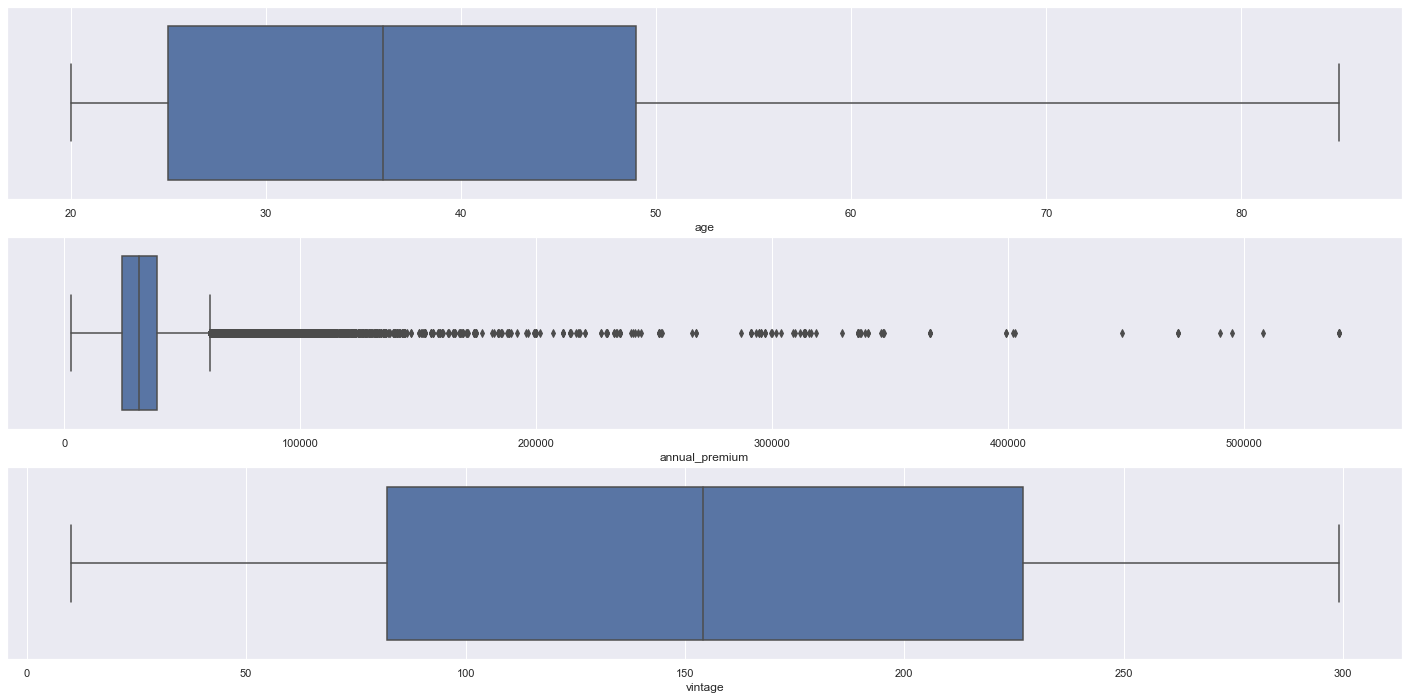

In [51]:
#ploting numerical attributes
plt.subplot(3,1,1)
sns.boxplot(num_attributes["age"])

plt.subplot(3,1,2)
sns.boxplot(num_attributes["annual_premium"])

plt.subplot(3,1,3)
sns.boxplot(num_attributes["vintage"])

### 1.5.2. Categorical Attributes

In [52]:
#define categorical attributes
cat_attributes = df1[["gender","vehicle_age","response","vehicle_damage","previously_insured", "driving_license"]]

<AxesSubplot:xlabel='driving_license', ylabel='count'>

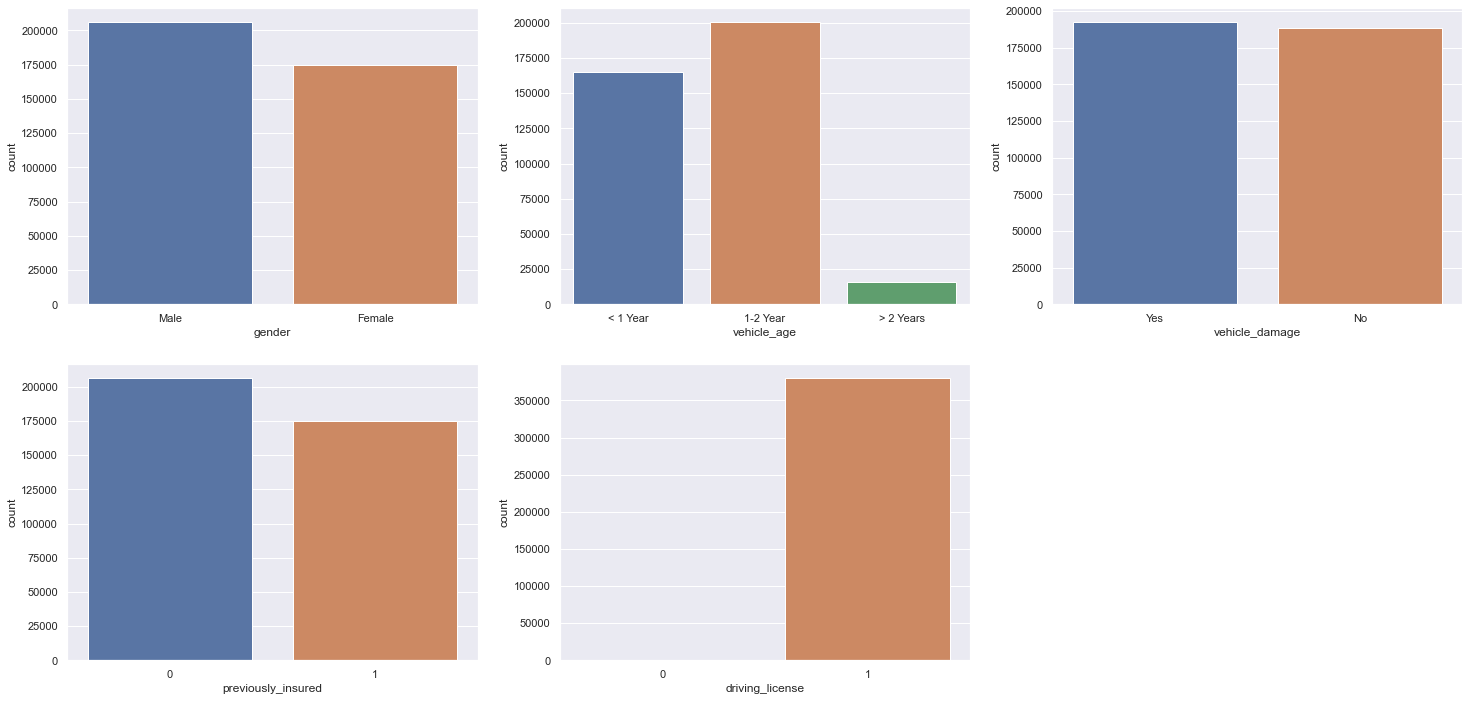

In [48]:
#plotting categorical variables
plt.subplot(2,3,1)
sns.countplot(cat_attributes["gender"])

plt.subplot(2,3,2)
sns.countplot(cat_attributes["vehicle_age"])

plt.subplot(2,3,3)
sns.countplot(cat_attributes["vehicle_damage"])

plt.subplot(2,3,4)
sns.countplot(cat_attributes["previously_insured"])

plt.subplot(2,3,5)
sns.countplot(cat_attributes["driving_license"])

<AxesSubplot:xlabel='response', ylabel='count'>

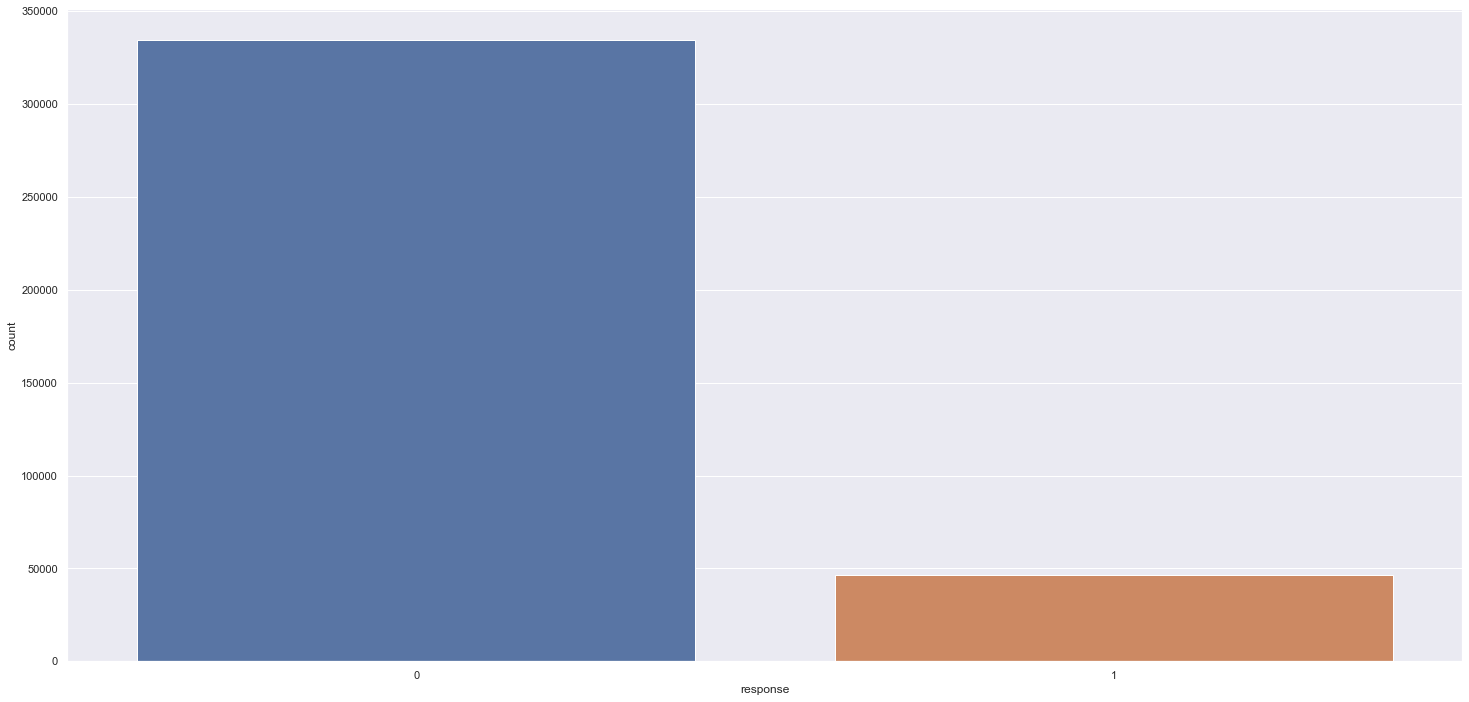

In [37]:
#response variable
sns.countplot(cat_attributes["response"])

# 2.0. FEATURE ENGINEERING

In [53]:
df2 = df1.copy()

In [54]:
#vehicle_age
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x:'over_2_years' if x == "> 2 Years" 
                                              else 'between_1_2_year' if x == '1-2 Years'
                                              else 'below_1_year')


#vehicle_damage
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)

In [55]:
df2.head()

,id,gender,age,region_code,contact_channel,driving_license,vehicle_age,vehicle_damage,previously_insured,annual_premium,vintage,response
0,0,Male,23,11.0,152.0,1,below_1_year,1,0,23367.0,249,0
1,1,Female,41,15.0,14.0,1,below_1_year,0,1,31409.0,221,0
2,2,Female,25,35.0,152.0,1,below_1_year,0,1,46622.0,299,0
3,3,Female,26,8.0,160.0,1,below_1_year,0,0,2630.0,136,0
4,4,Male,45,8.0,124.0,1,below_1_year,1,0,42297.0,264,0


# 3.0. EXPLORATORY DATA ANALYSIS

In [59]:
df3 = df2.copy()

## 3.1. Univariate Analysis

### 3.1.1. Numerical Features 

(array([12877., 13306., 11981., 13108., 13124., 11804., 13382., 13181.,
        11833., 13174., 11878., 13161., 13262., 11779., 13110., 13178.,
        11745., 12874., 13323., 11915., 12912., 11876., 13131., 13073.,
        11996., 13258., 13027., 11620., 13150., 13071.]),
 array([ 10.        ,  19.63333333,  29.26666667,  38.9       ,
         48.53333333,  58.16666667,  67.8       ,  77.43333333,
         87.06666667,  96.7       , 106.33333333, 115.96666667,
        125.6       , 135.23333333, 144.86666667, 154.5       ,
        164.13333333, 173.76666667, 183.4       , 193.03333333,
        202.66666667, 212.3       , 221.93333333, 231.56666667,
        241.2       , 250.83333333, 260.46666667, 270.1       ,
        279.73333333, 289.36666667, 299.        ]),
 <BarContainer object of 30 artists>)

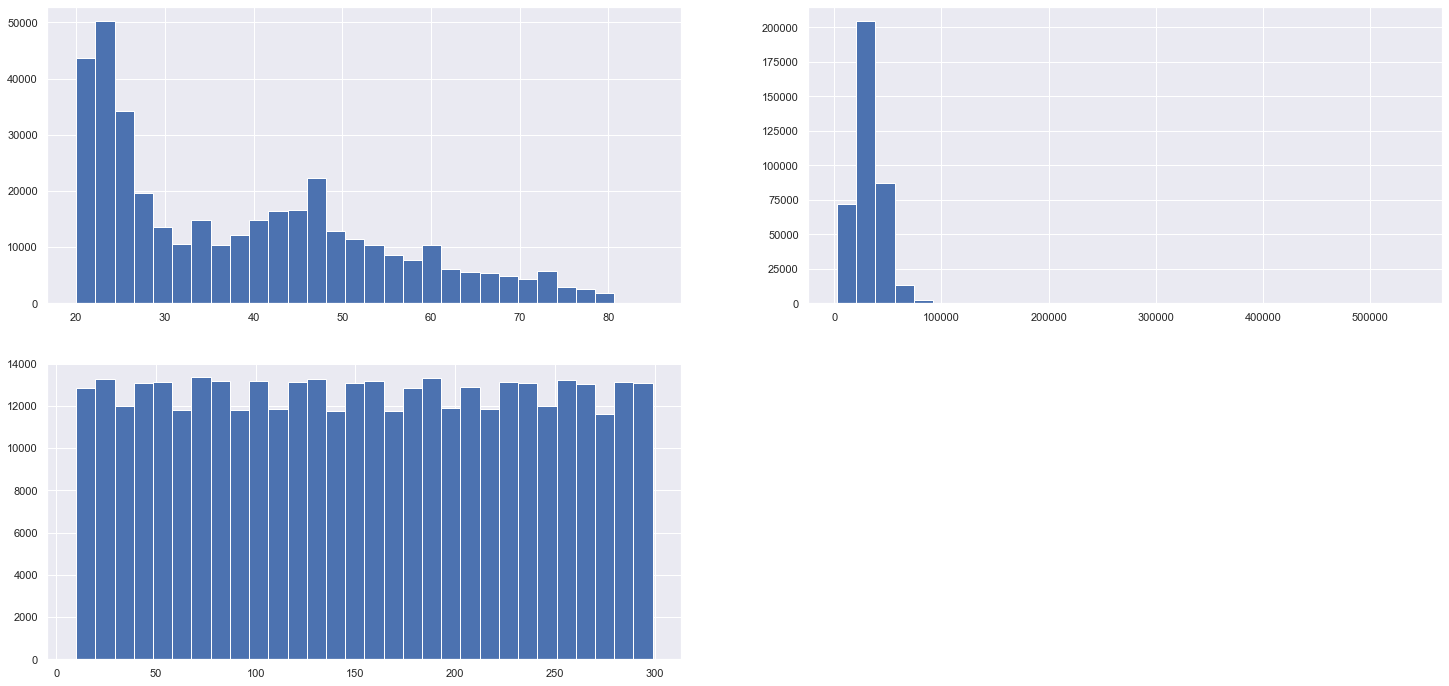

In [68]:
plt.subplot(2,2,1)
plt.hist(num_attributes["age"], bins=30)

plt.subplot(2,2,2)
plt.hist(num_attributes["annual_premium"], bins=30)

plt.subplot(2,2,3)
plt.hist(num_attributes["vintage"], bins=30)

## 3.2. Bivariate Analysis

### 3.2.1. Gender

In [ ]:
vehicle_damage,previously_insured, response

### 3.2.1. Age

Text(0.5, 1.0, 'Customers interested by age')

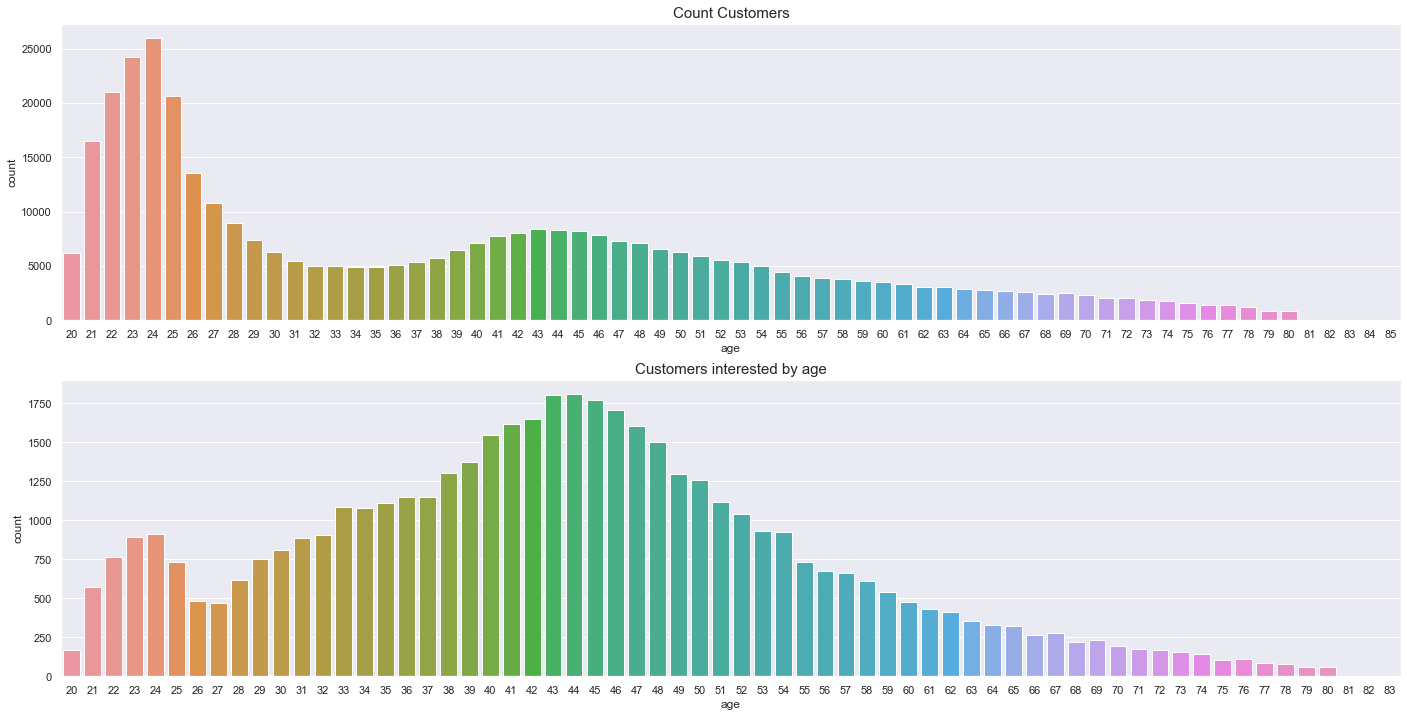

In [15]:
#count age
plt.figure(figsize = (24,12))
plt.subplot(2,1,1)
sns.countplot(df3['age']);
plt.title("Count Customers", fontsize = 15)
#
plt.subplot(2,1,2)
aux = df3.loc[df3['response'] == 1]
sns.countplot(aux['age']);
plt.title("Customers interested by age", fontsize = 15)

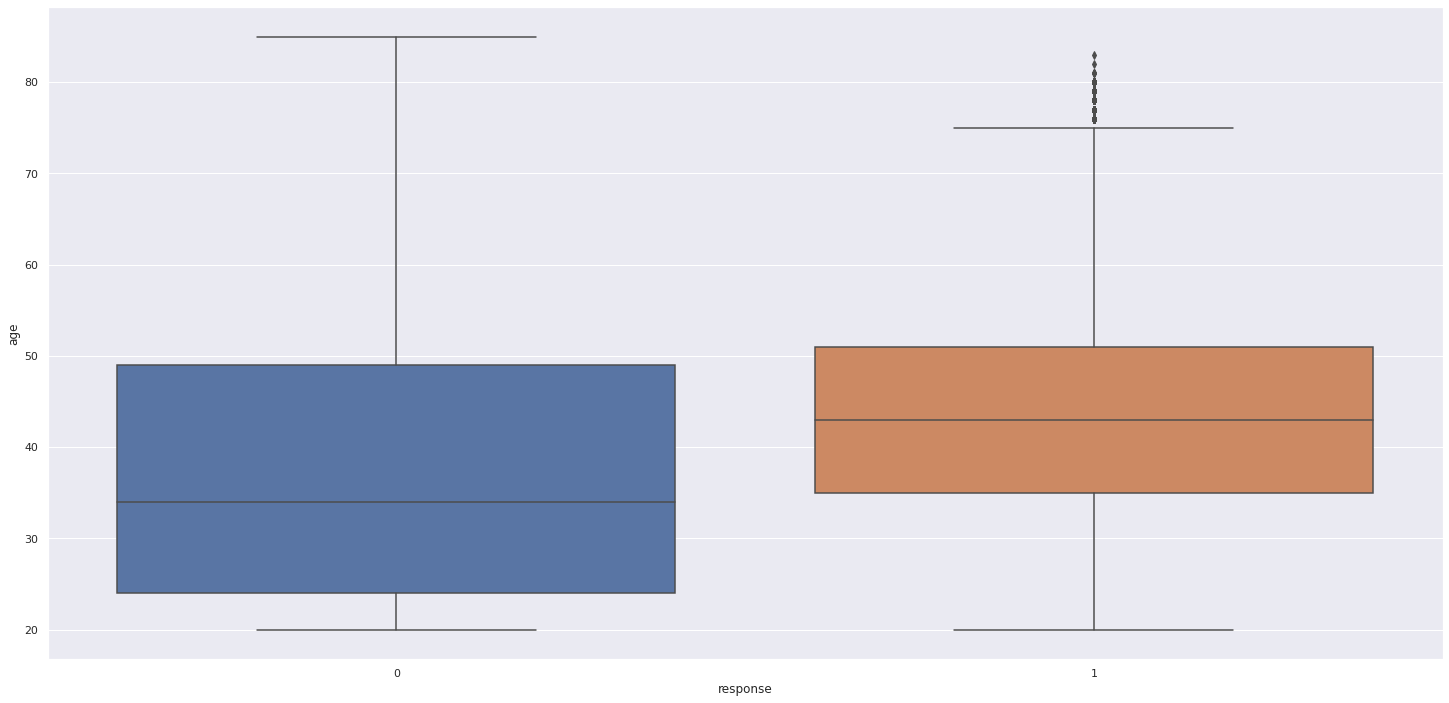

In [ ]:
#response x age -> boxplot
sns.boxplot(x = 'response', y = 'age', data = df3 )

### 3.2.2. Anual Income

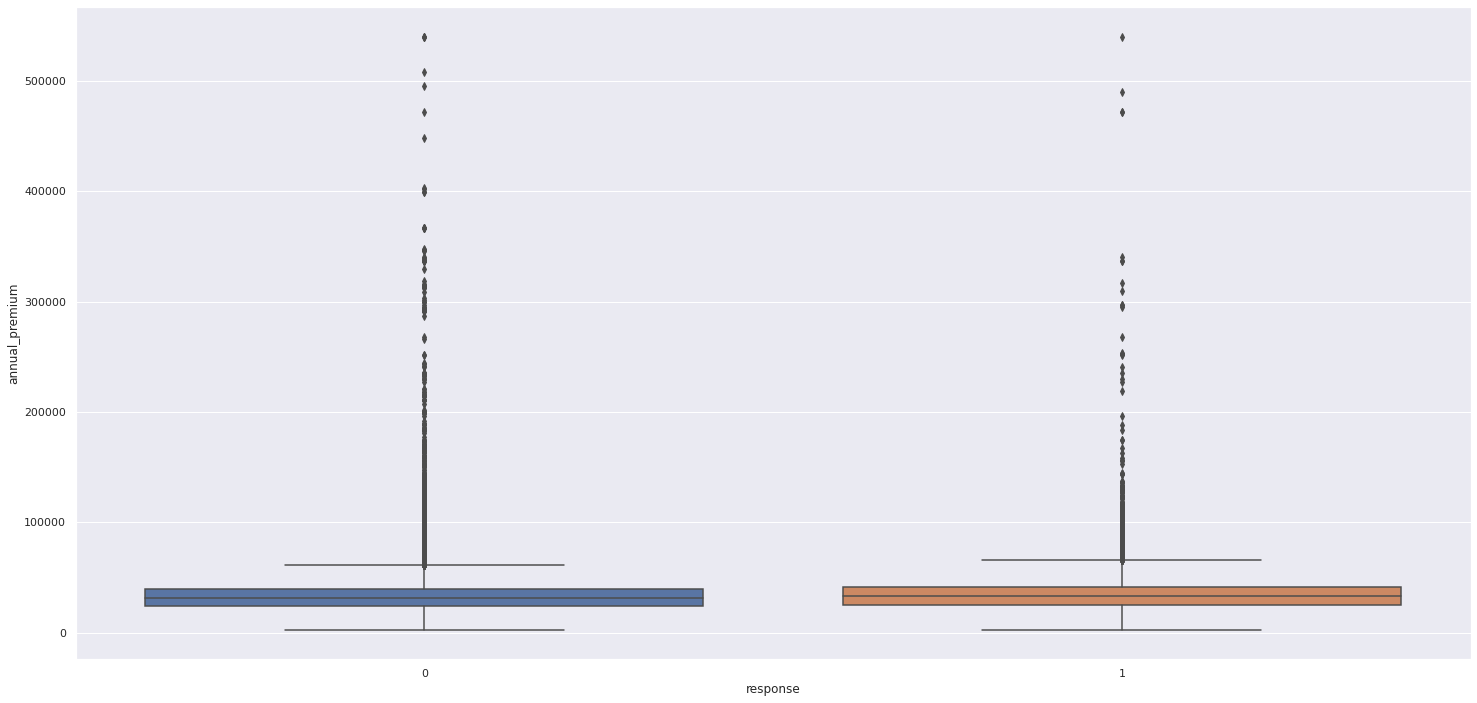

In [ ]:
#boxplot
sns.boxplot(x = 'response', y = 'annual_premium', data = df3)

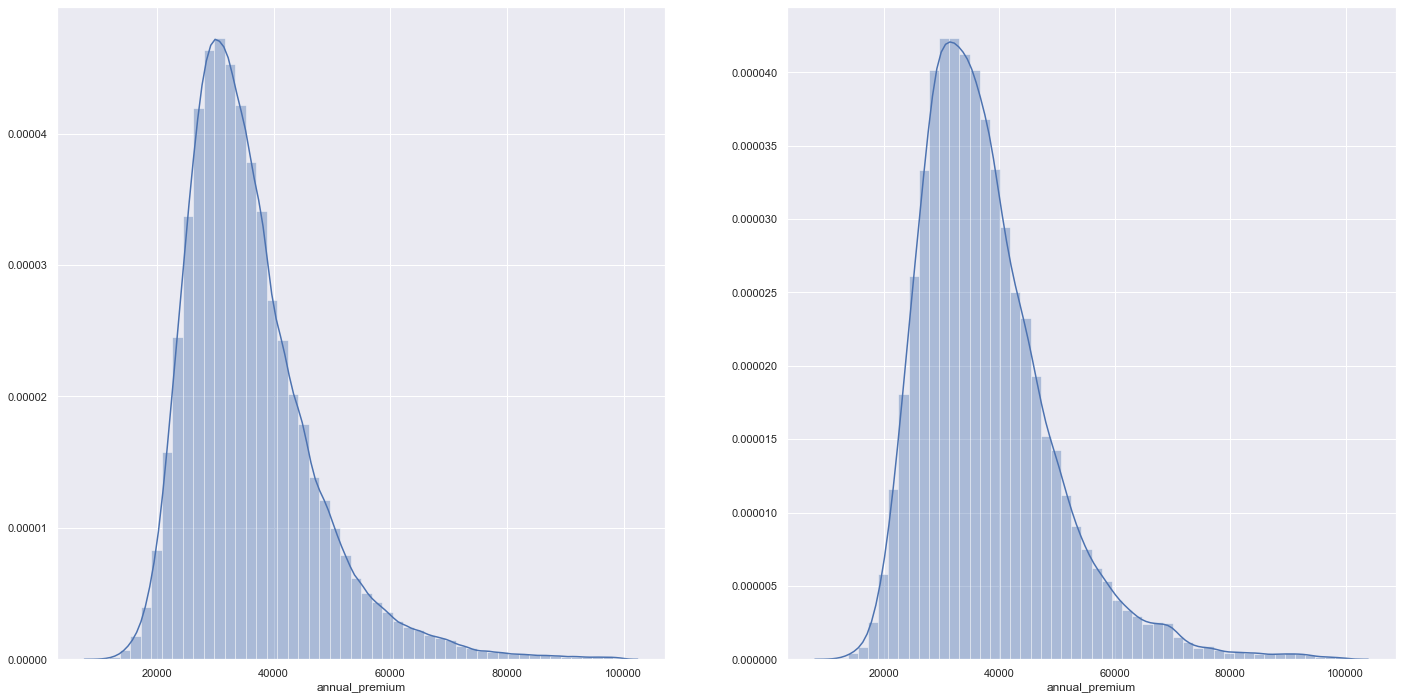

In [16]:
aux = df3[(df3['annual_premium'] > 10000) &(df3['annual_premium'] < 100000)] 

#filter response equal 0
aux00 = aux.loc[aux['response'] == 0, 'annual_premium']
#filter response equal 1 
aux01 = aux.loc[aux['response'] == 1, 'annual_premium']

fig = plt.figure(figsize = (24,12))
spec = gridspec.GridSpec(ncols = 2, nrows = 1, figure = fig)
ax1 = fig.add_subplot(spec[:,0])
ax2 = fig.add_subplot(spec[:,1])

sns.distplot(aux00, ax = ax1)
sns.distplot(aux01, ax = ax2)

### 3.2.3. Previously Insured

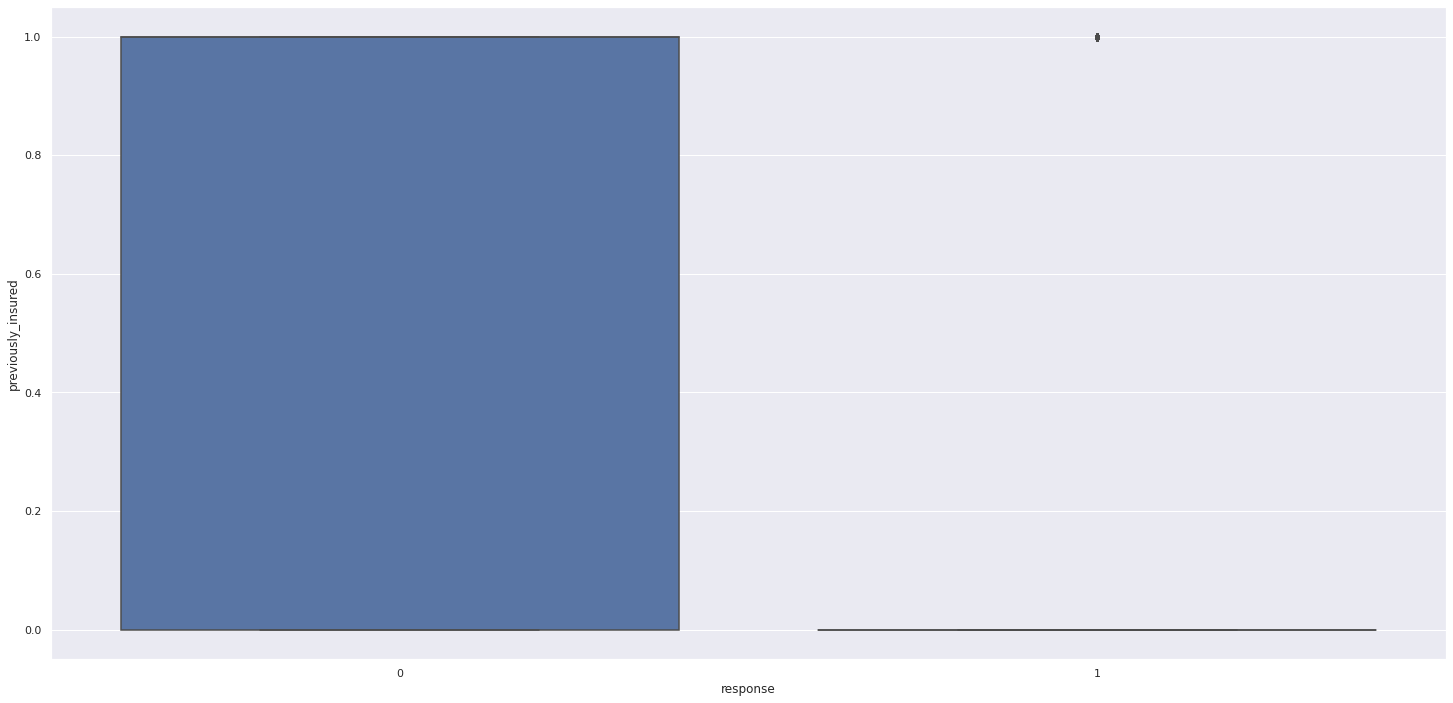

In [ ]:
#boxplot
sns.boxplot(x = 'response', y = 'previously_insured', data = df3);

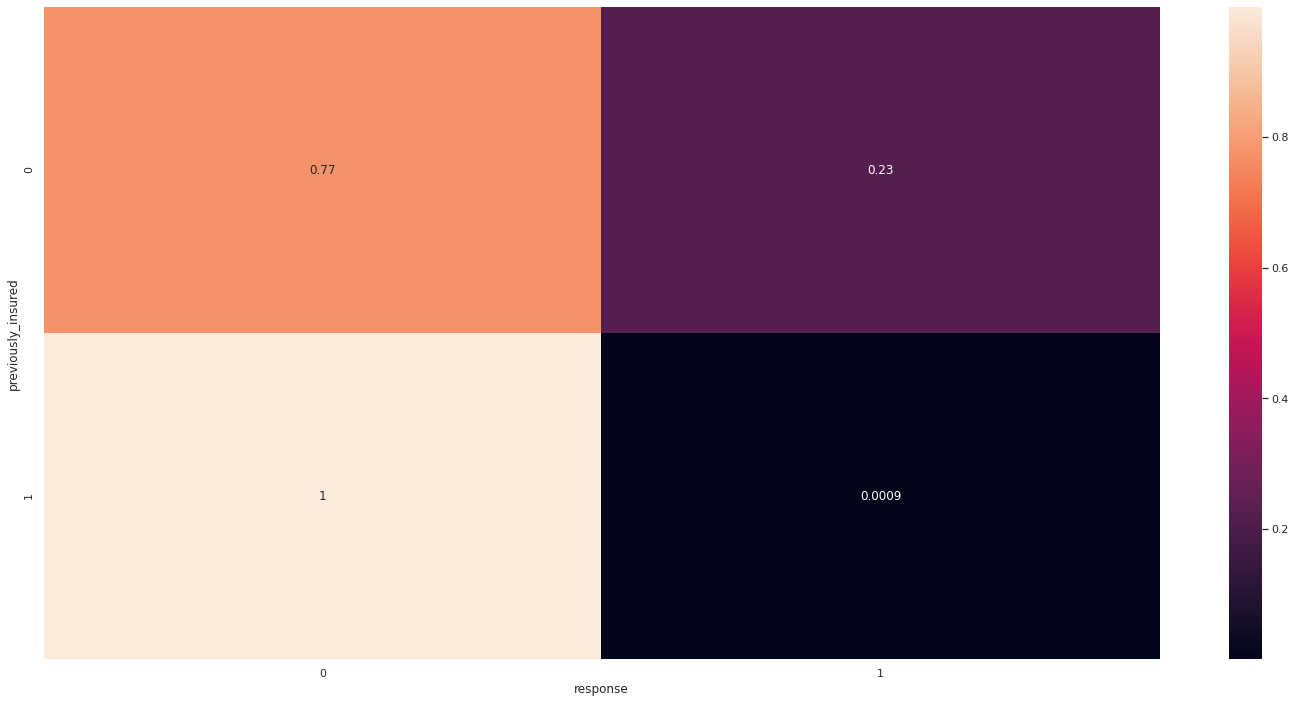

In [ ]:
aux00 = pd.crosstab(df3['previously_insured'], df3['response'] ).apply( lambda x: x / x.sum(), axis=1 )
sns.heatmap(aux00, annot = True)

### 3.2.4. Vehicle Damage


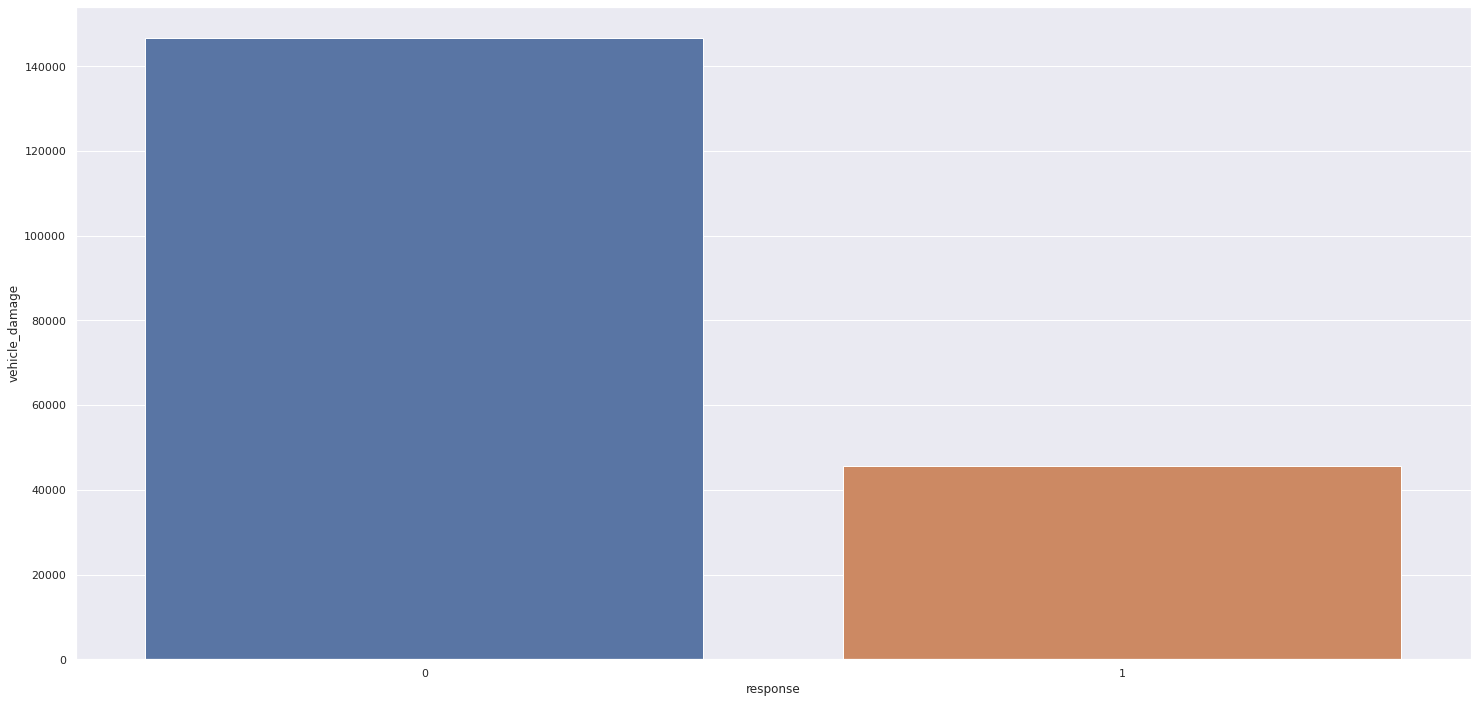

In [ ]:
aux = df3[['vehicle_damage', 'response']].groupby( 'response' ).sum().reset_index()
sns.barplot( x='response', y='vehicle_damage', data=aux );

### 3.2.5. Policy Sales Channel

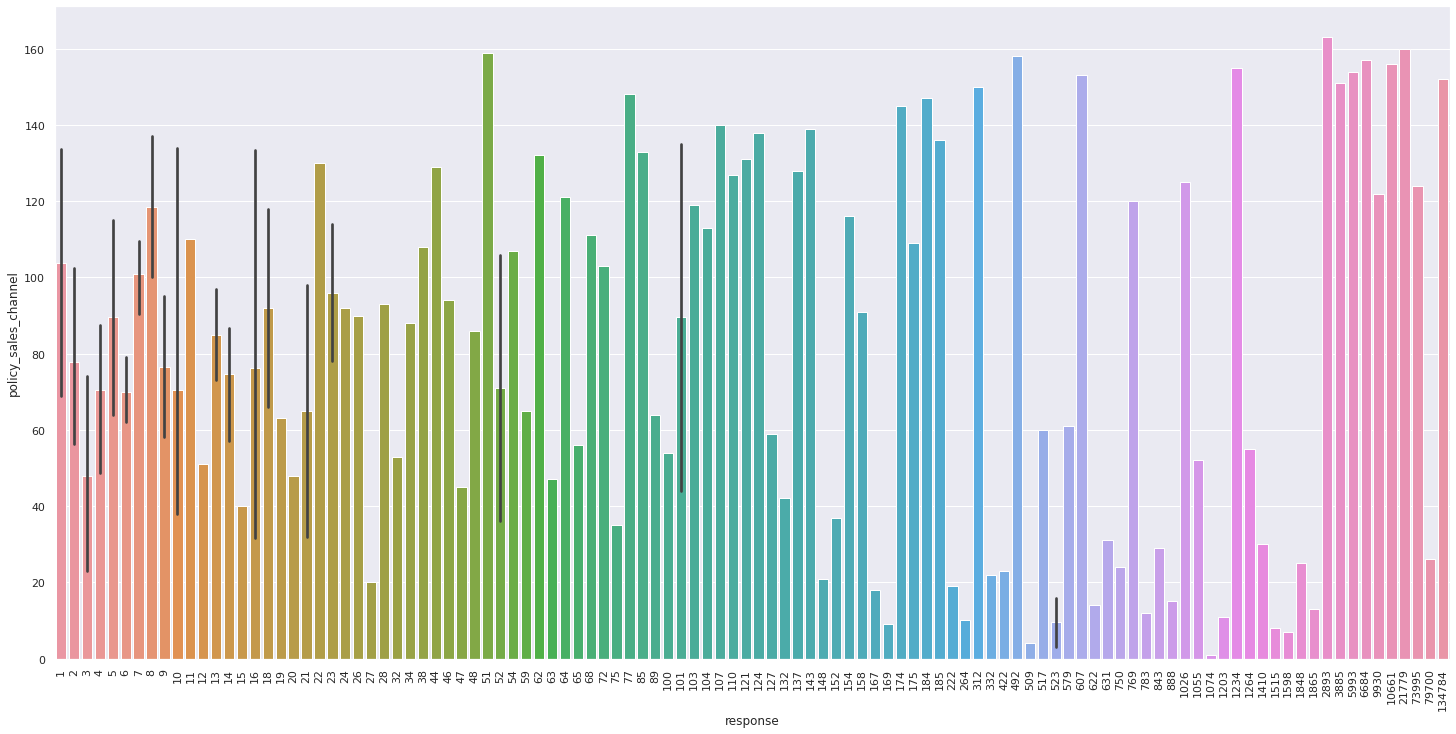

In [ ]:
aux = df3[['policy_sales_channel', 'response']].groupby( 'policy_sales_channel' ).count().reset_index()
sns.barplot( x='response', y='policy_sales_channel', data=aux );
plt.xticks(rotation = 90);

### 3.2.6. Vintage

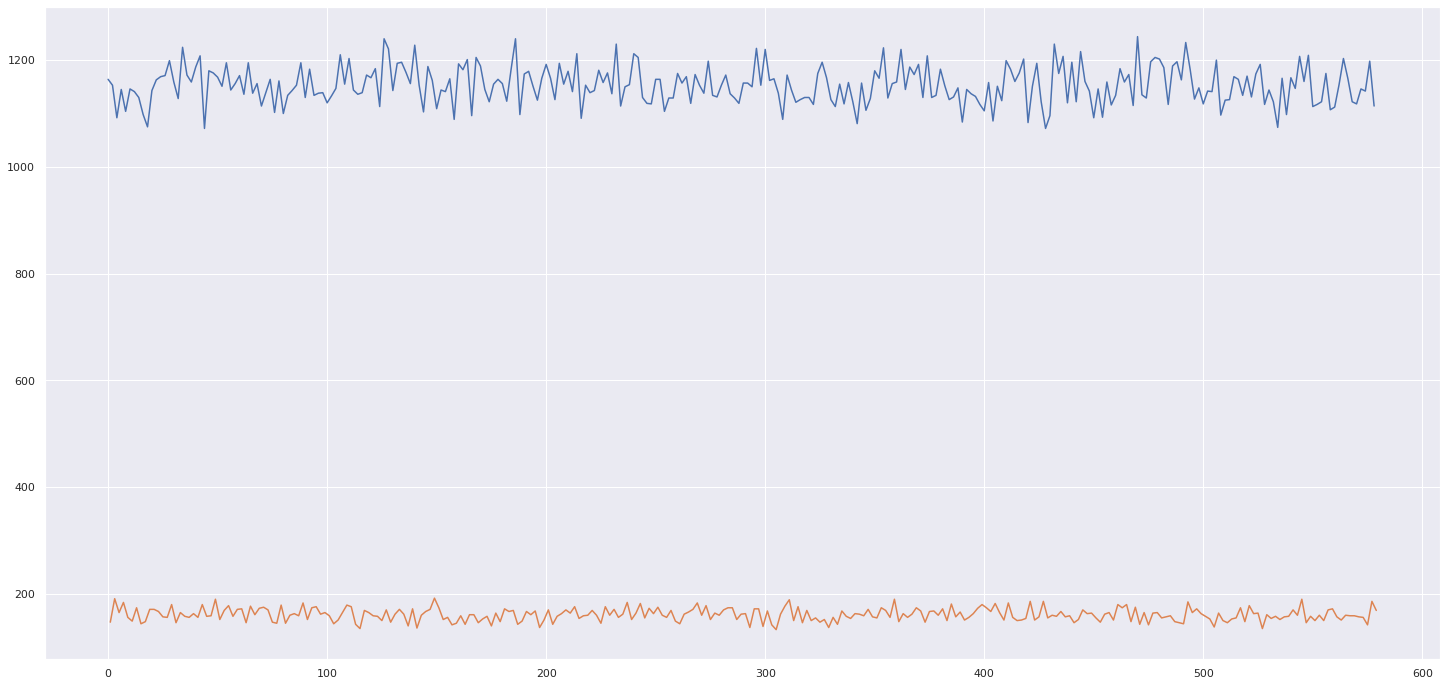

In [ ]:
aux = df3[['vintage','response']].groupby(["vintage",'response']).size().reset_index()

aux00 = aux.loc[aux['response'] == 0, 0]
aux01 = aux.loc[aux['response'] == 1, 0]
aux00.plot()
aux01.plot()

## 3.3 Multivariate analysis

<AxesSubplot:>

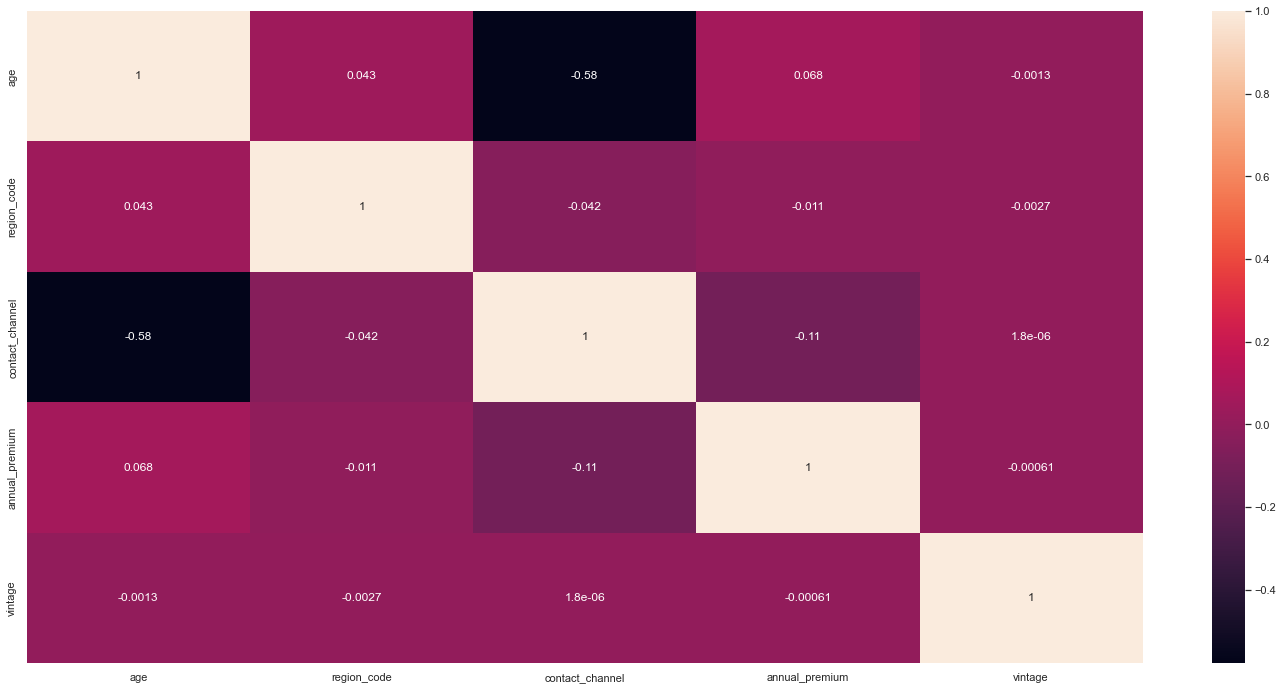

In [71]:
#separating numerical variables and building the heat map
num_attributes_c=df3[['age', 'region_code', 'contact_channel','driving_license', 'vehicle_damage','previously_insured', 'annual_premium', 'vintage']]

correlation = num_attributes.corr(method = 'pearson')
sns.heatmap(correlation, annot = True)

# 4.0. DATA PREPARATION

In [72]:
#copy dataframe
df4 = df3.copy()

## 4.1. Split data into training and test

In [73]:
#predict variables
X = df4.drop(columns = ['response'], axis = 1)
#target variable
y = df4['response']

#Split data
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size = 0.2, random_state = 42)

## 4.2. Rescaling

<AxesSubplot:xlabel='vintage'>

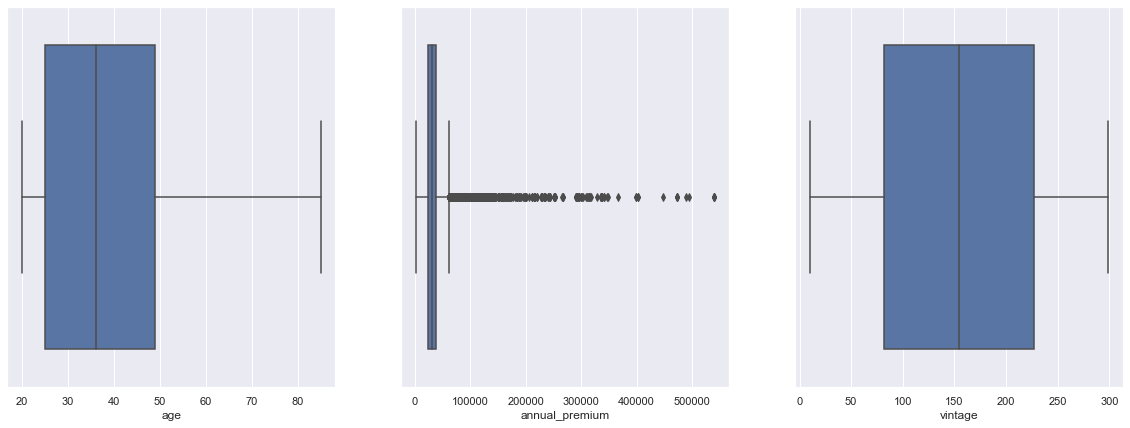

In [74]:
fig = plt.figure(figsize = (20,7))
spec = gridspec.GridSpec(ncols = 3, nrows = 1, figure = fig)

ax1 = fig.add_subplot(spec[:,0])
ax2 = fig.add_subplot(spec[:,1])
ax3 = fig.add_subplot(spec[:,2])

#age 
sns.boxplot(X_train['age'], ax = ax1)
#annual_premium
sns.boxplot(X_train['annual_premium'], ax = ax2)
#vintage
sns.boxplot(X_train['vintage'], ax = ax3)

In [47]:
#models
rs = RobustScaler()
mms = MinMaxScaler()

#age
X_train['age'] = mms.fit_transform(X_train[['age']])
X_val['age'] = mms.transform(X_val[['age']])
#pickle.dump(mms, open("C:/ProjetosDataScience/20210125_pa004/parameters/rescaling_age.pkl",'wb'))

#annual_premium
X_train['annual_premium'] = rs.fit_transform(X_train[['annual_premium']])
X_val['annual_premium'] = rs.transform(X_val[['annual_premium']])
#pickle.dump(rs, open(main_path + 'rescaling_annual_premium.pkl','wb'))

#vintage
X_train['vintage'] = mms.fit_transform(X_train[['vintage']])
X_val['vintage'] = mms.transform(X_val[['vintage']])
#pickle.dump(mms, open(main_path + "/rescaling_vintage.pkl",'wb'))

## 4.3. Encoding

In [44]:
#concat predict and target variables
df43 = pd.concat([X_train,y_train], axis = 1)

In [46]:
#gender
target_encode_gender  = df43.groupby('gender')['response'].mean()
df43.loc[:,'gender'] = df43['gender'].map(target_encode_gender)
#pickle.dump(target_encode_gender, open(main_path + '/target_encode_gender.pkl','wb'))

# region_code
target_encode_region_code  = df43.groupby("region_code")['response'].mean()
df43.loc[:,'region_code'] = df43['region_code'].map(target_encode_region_code)
#pickle.dump(target_encode_region_code, open(main_path + '/target_encode_region_code.pkl','wb'))

#policy_sales_channel
fe_policy_sales_channel  = df43.groupby("policy_sales_channel").size()/len(df43)
df43.loc[:,'policy_sales_channel'] = df43['policy_sales_channel'].map(fe_policy_sales_channel)
#pickle.dump(fe_policy_sales_channel, open(main_path + '/fe_policy_sales_channel.pkl','wb'))

#vehicle_age
df43 = pd.get_dummies(df43, prefix = 'vehicle_age', columns = ['vehicle_age'])

#-------------------------------------------------------------- VALIDATION DATA ------------------------------------------------------------
df43_val = pd.concat([X_val,y_val], axis = 1)

#gender
df43_val.loc[:,'gender'] = df43_val['gender'].map(target_encode_gender)
#region_code
df43_val.loc[:,'region_code'] = df43_val['region_code'].map(target_encode_region_code)
#policy_sales_channel
df43_val.loc[:,'policy_sales_channel'] = df43_val['policy_sales_channel'].map(fe_policy_sales_channel)
#vehicle_age
df43_val = pd.get_dummies(df43_val, prefix = 'vehicle_age', columns = ['vehicle_age'])

# 5.0. FEATURE SELECTION

## 5.1. Random Forest as Feature Selector

In [58]:
# model definition
forest = ExtraTreesClassifier( n_estimators=250, random_state=0, n_jobs=-1 )

# data preparation
x_train_n = df43.drop( ['Unnamed: 0', 'response'], axis=1 )
y_train_n = y_train.values
forest.fit( x_train_n, y_train_n )

ExtraTreesClassifier(n_estimators=250, n_jobs=-1, random_state=0)

Feature ranking:
                    feature  importance
0                   vintage    0.277817
0            annual_premium    0.247994
0                       age    0.169765
0               region_code    0.102295
0            vehicle_damage    0.073103
0      policy_sales_channel    0.062643
0        previously_insured    0.056980
0                    gender    0.004610
0  vehicle_age_below_1_year    0.002278
0  vehicle_age_over_2_years    0.002022
0           driving_license    0.000493


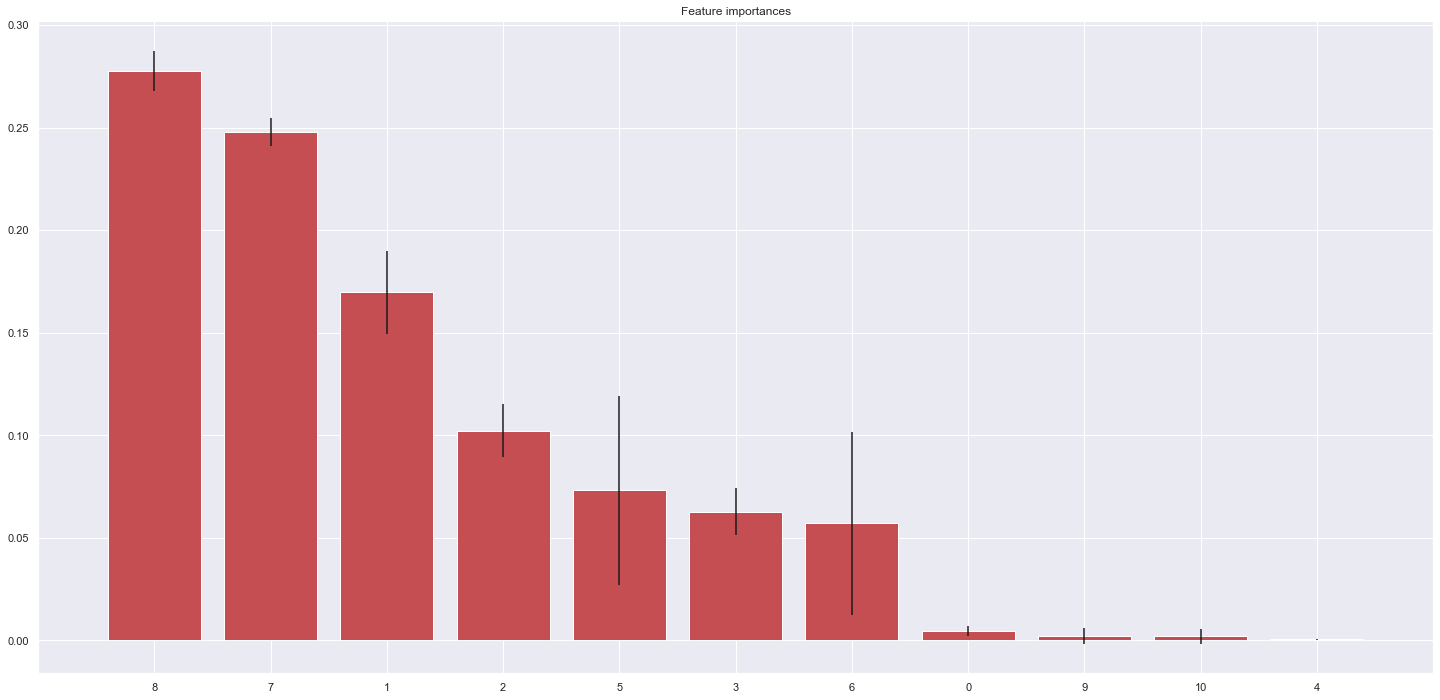

In [59]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
df = pd.DataFrame()
for i, j in zip( x_train_n, forest.feature_importances_ ):
    aux = pd.DataFrame( {'feature': i, 'importance': j}, index=[0] )
    df = pd.concat( [df, aux], axis=0 )
    
print( df.sort_values( 'importance', ascending=False ) )

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(x_train_n.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(x_train_n.shape[1]), indices)
plt.xlim([-1, x_train_n.shape[1]])
plt.show()

## 5.2. Manual Feature Selection

In [48]:
manual_feature_selection = ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

#predict features
X_train = df43[manual_feature_selection]
X_val = df43_val[manual_feature_selection]

#target features
y_train = df43['response']
y_val = df43_val['response']

# 6.0. MACHINE LEARNING MODELLING

## 6.1. Logistic Regression

In [50]:
X_val['policy_sales_channel'] = X_val['policy_sales_channel'].fillna(X_val['policy_sales_channel'].mean())
X_train['policy_sales_channel'] = X_train['policy_sales_channel'].fillna(X_train['policy_sales_channel'].mean())

In [121]:
#model
lr = LogisticRegression(random_state = 42)

#fit model
lr.fit(X_train,y_train)

#predict model
yhat_lr = lr.predict_proba(X_val)

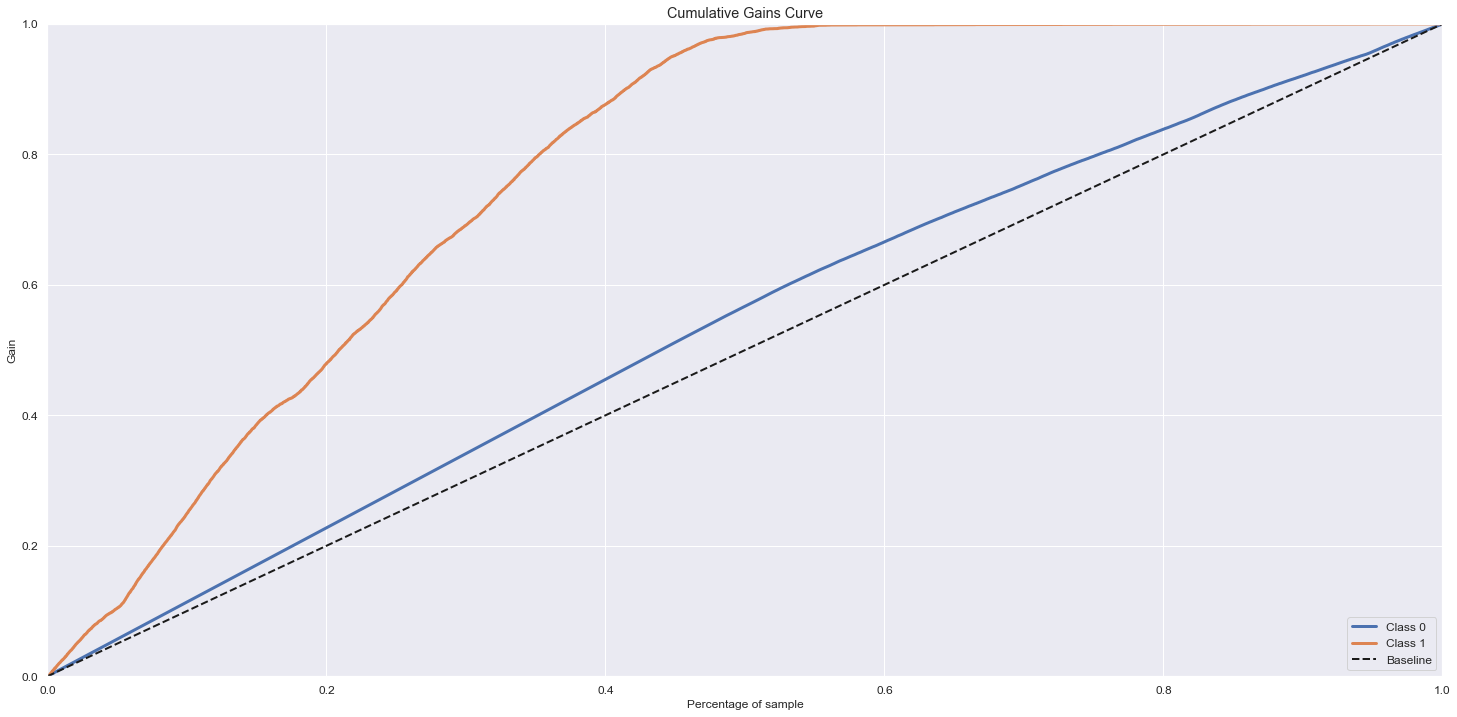

In [126]:
## Accumulative Gain
skplt.metrics.plot_cumulative_gain( y_val, yhat_lr ); 

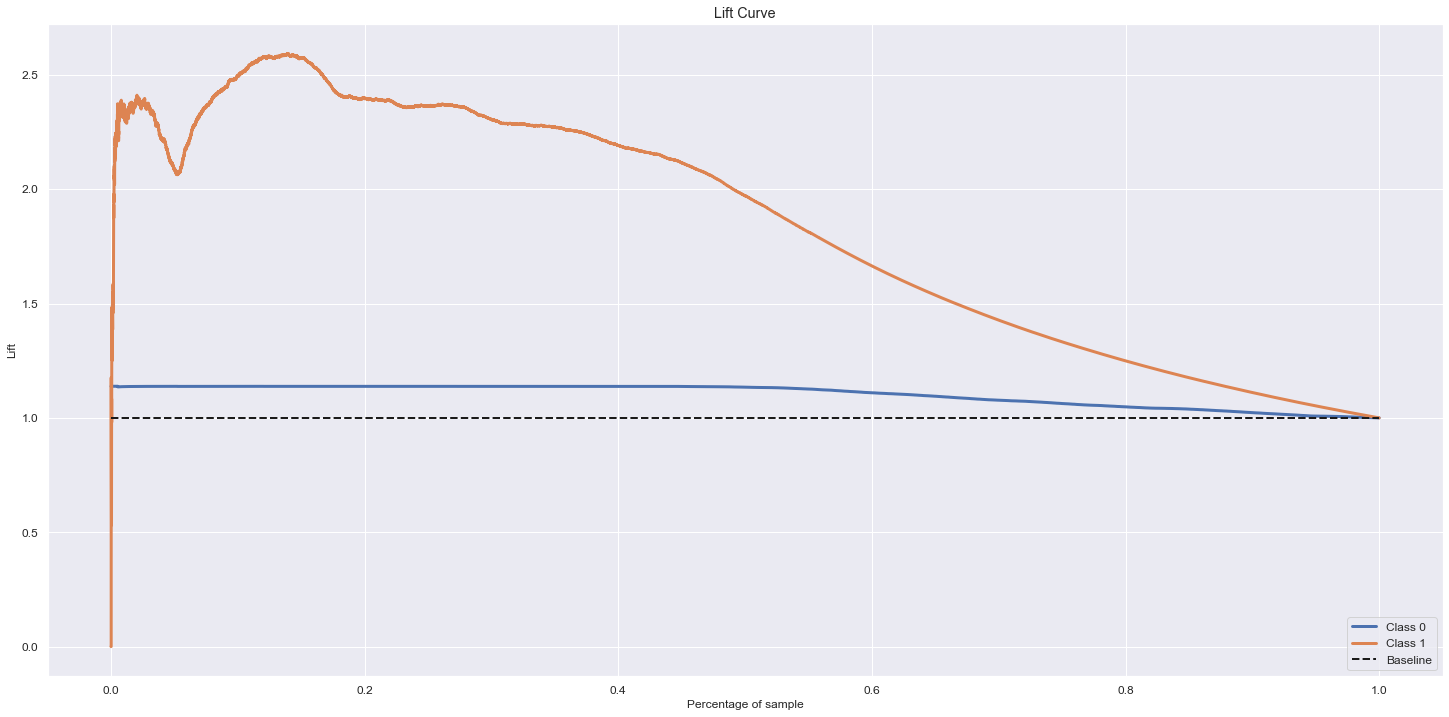

In [127]:
#Scikitplot library is there to help
skplt.metrics.plot_lift_curve( y_val, yhat_lr )

## 6.2. Random Forest Classifier

In [51]:
#model
rf = RandomForestClassifier(n_jobs = -1)
pickle.dump(rf,open('C:/ProjetosDataScience/20210125_pa004/webapp/model/model_rf.pkl','wb'))

#fit model
rf.fit(X_train,y_train)

#predict proba
yhat_rf = rf.predict_proba(X_val)

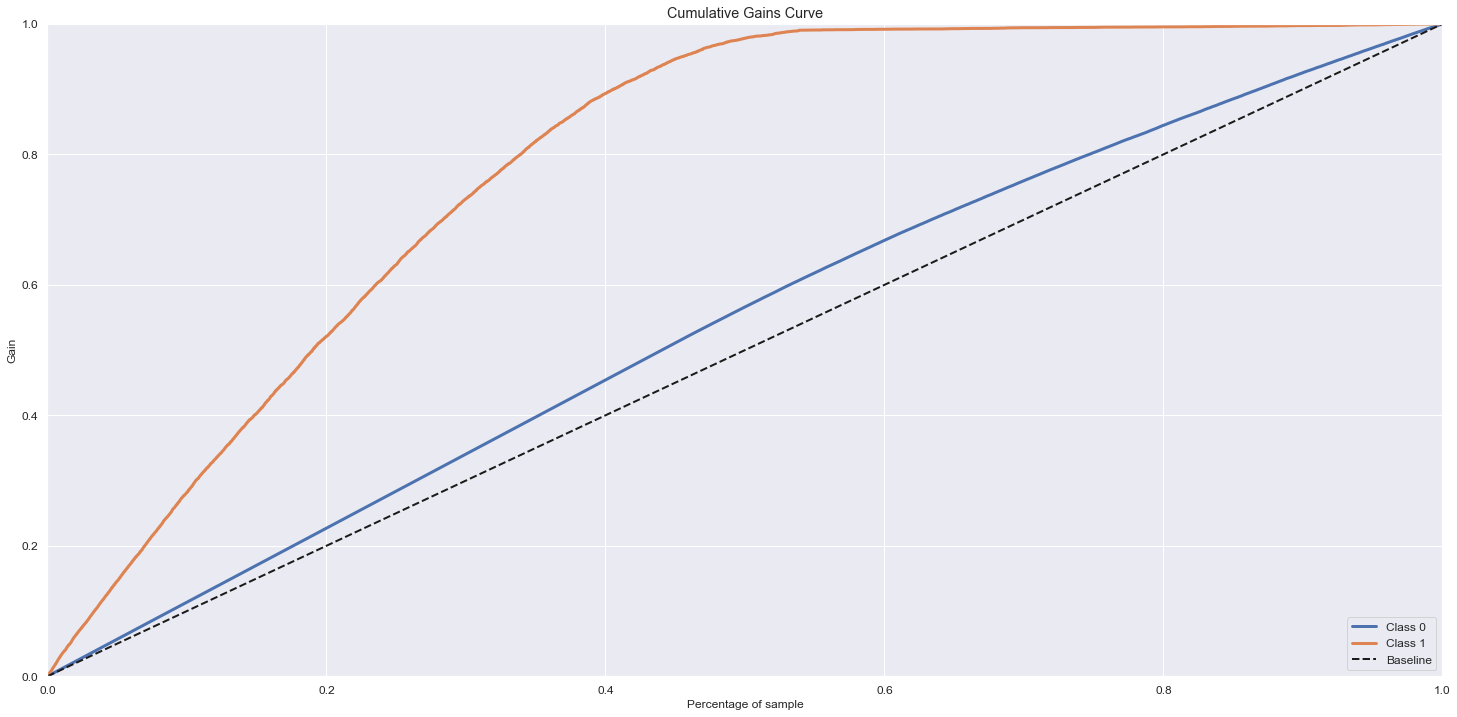

In [134]:
#Accumaltive Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_rf);

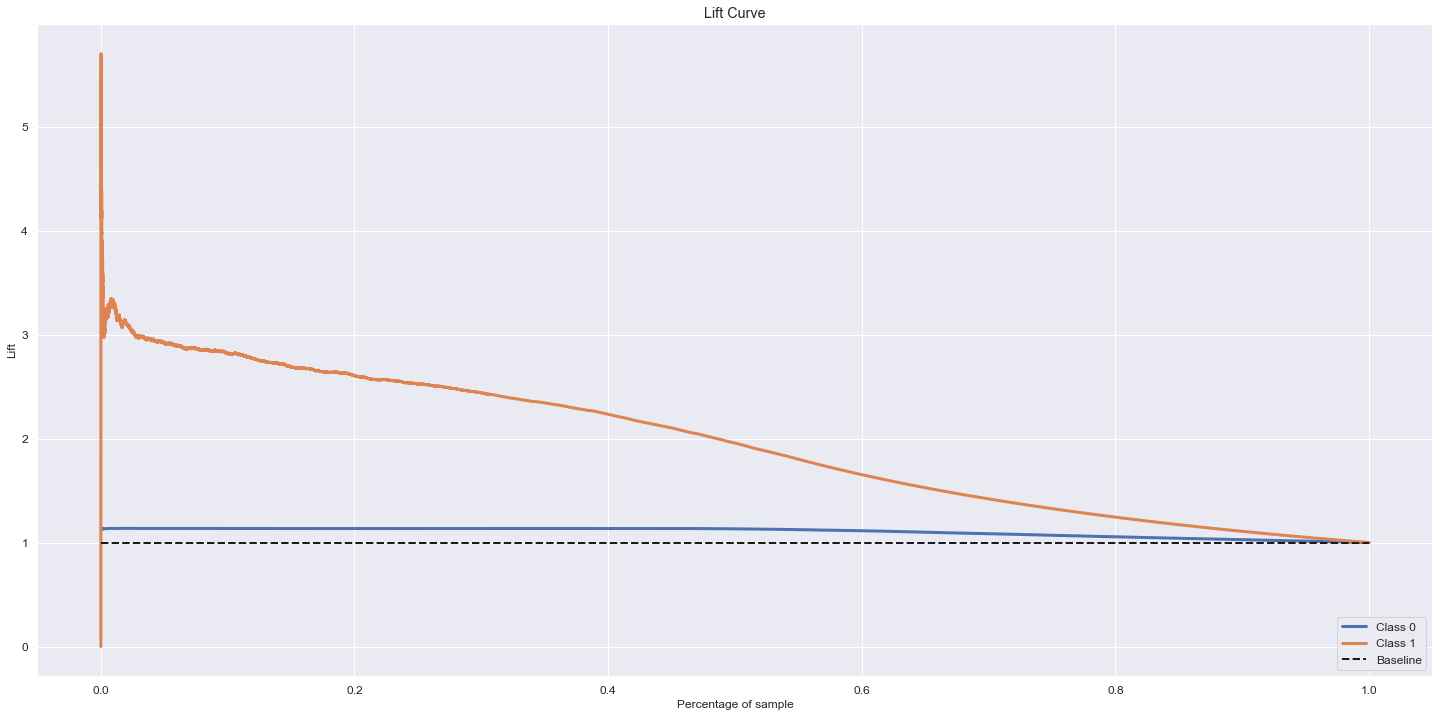

In [136]:
#lifc curve
skplt.metrics.plot_lift_curve(y_val,yhat_rf);

## 6.3. K-Nearest Neighbors Classifier 

In [61]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)
pickle.dump(knn_model,open('C:/ProjetosDataScience/20210125_pa004/webapp/model/model_knn.pkl','wb'))

# model training
knn_model.fit(X_train, y_train)

# model prediction
yhat_knn = knn_model.predict_proba(X_val)

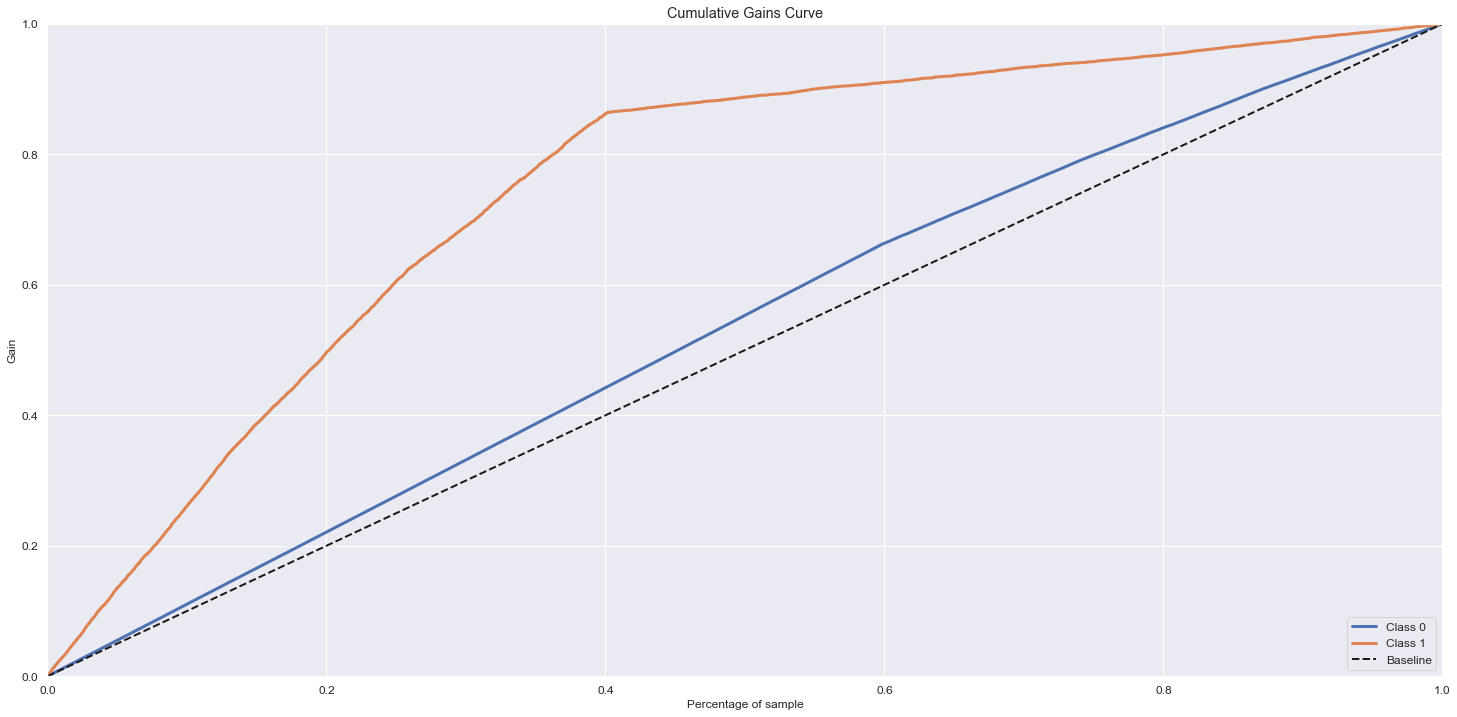

In [145]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_knn);

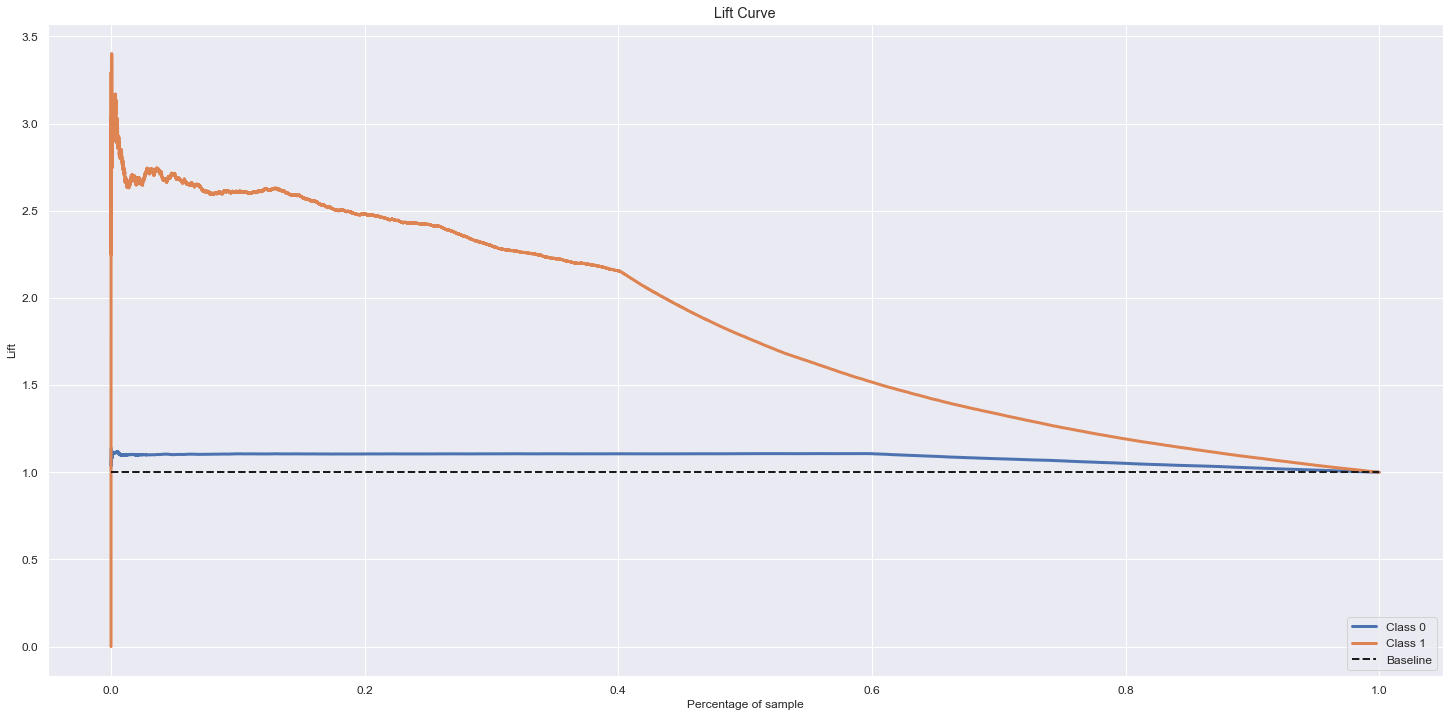

In [146]:
#lift curve
skplt.metrics.plot_lift_curve(y_val,yhat_knn);

## 6.4. Extra Tress Classifier

In [33]:
# model definition
et = ExtraTreesClassifier(n_jobs=-1) 

# model training
et.fit(X_train, y_train)

# model prediction
yhat_et = et.predict_proba(X_val)

In [34]:
pickle.dump(et , open(main_path + "model.pkl",'wb'))

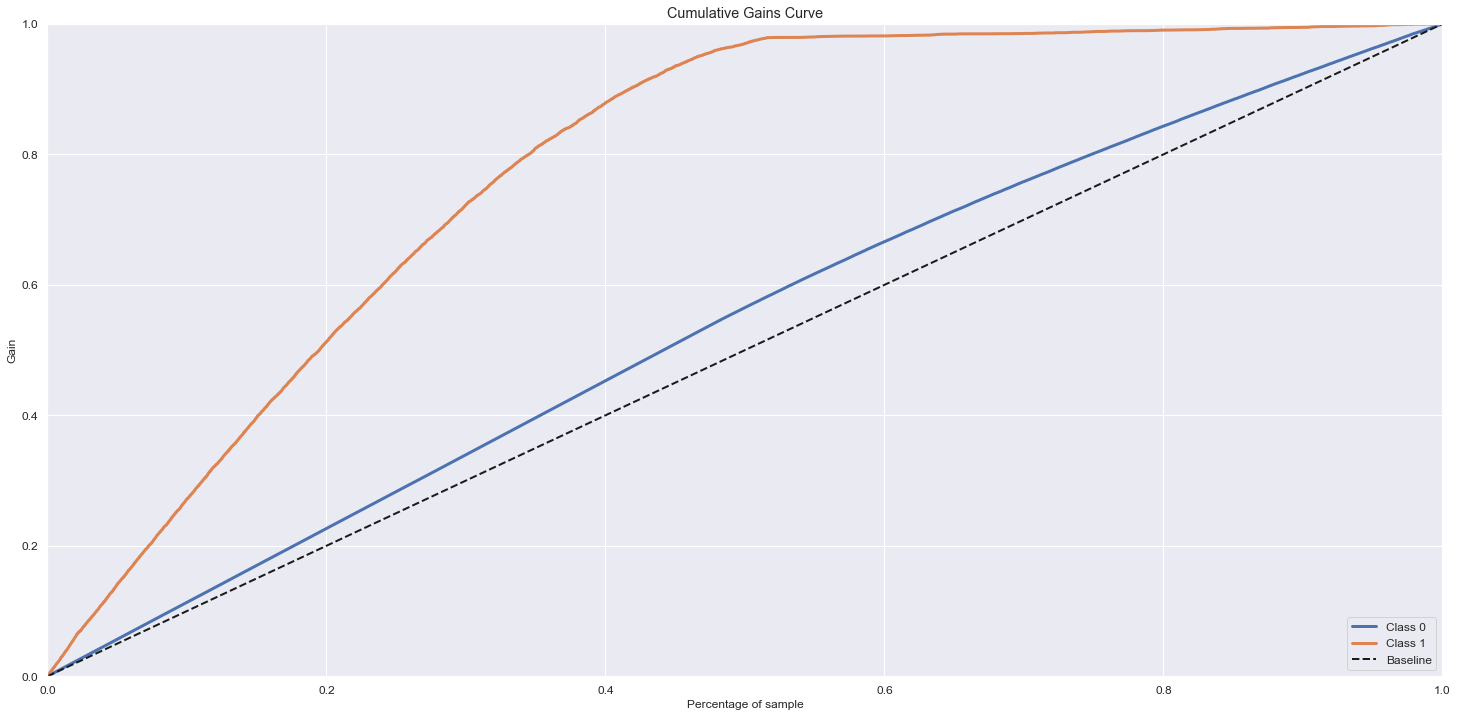

In [35]:
#Accumulative Gain
skplt.metrics.plot_cumulative_gain(y_val,yhat_et);

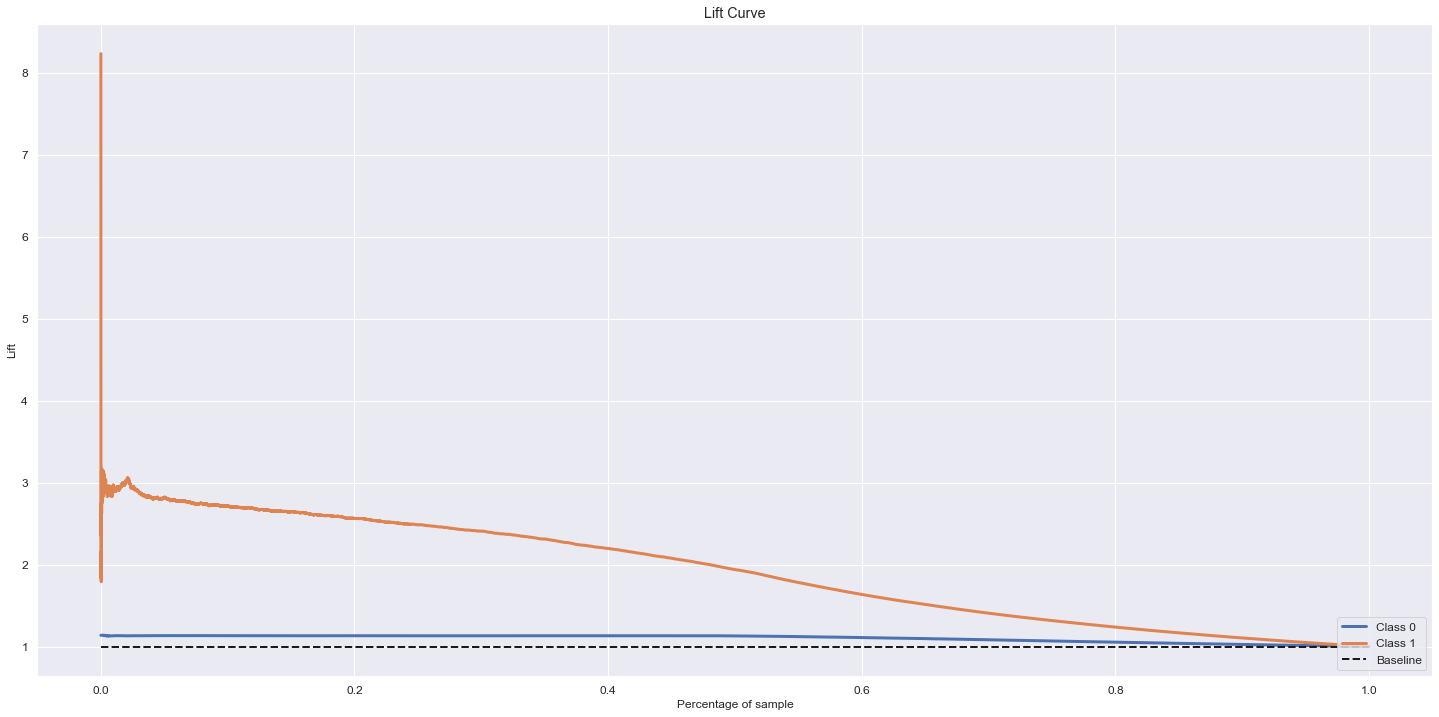

In [36]:
#lift curve
skplt.metrics.plot_lift_curve(y_val,yhat_et);

# 7.0. PERFORMANCE METRICS 

In [37]:
def precision_at_k( data, k=10 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['precision_at_k'] = data['response'].cumsum() / data['ranking']
    
    return ( data.loc[ k, 'precision_at_k'], data )

def recall_at_k( data, k=15 ):
    data = data.reset_index( drop=True )
    data['ranking'] = data.index + 1
    
    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()
    
    return ( data.loc[ k, 'recall_at_k'], data )

In [38]:
#copy data
df7 = X_val.copy()
df7['response'] = y_val

#score customers
df7['score'] = yhat_et[:,1].tolist()

#sort values
df7 = df7.sort_values("score", ascending = False)

# compute precision at k 
precision_at_20, data = precision_at_k( df7, k=20 )

# compute recall at k
recall_at_15, data = recall_at_k( df7, k=15 )

In [39]:
df7.head()

,vintage,annual_premium,age,region_code,vehicle_damage,policy_sales_channel,previously_insured,response,score
27800,0.653979,0.820610,0.415385,0.187326,1,0.209927,0,0,1.0
250608,0.003460,-1.936451,0.492308,0.187326,1,0.194003,0,0,1.0
364734,0.941176,-0.306088,0.246154,0.102644,1,0.209927,0,0,1.0
175242,0.761246,-1.936451,0.353846,0.121966,1,0.209927,0,0,1.0
112632,0.093426,-1.936451,0.461538,0.096875,1,0.209927,0,0,1.0


## 7.1. Cummulative Curve Manually

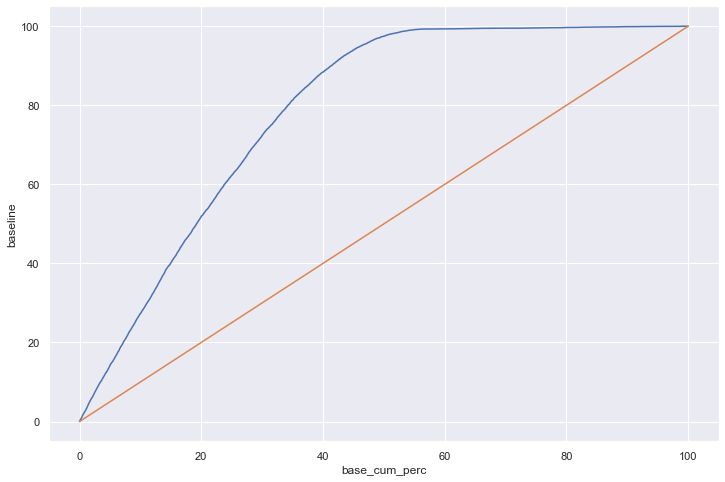

In [156]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='real_cum_perc', data=results )
sns.lineplot( x='base_cum_perc', y='baseline', data=results )

## 7.2. Lift Curve Manually

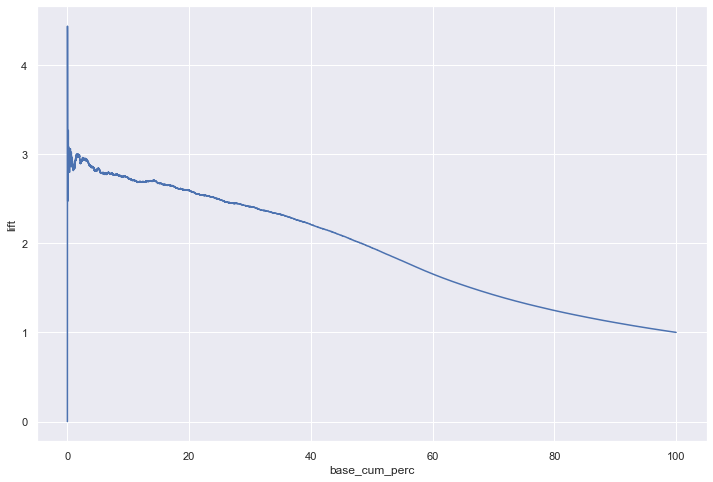

In [157]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

## 7.3. ROI Curve Manually

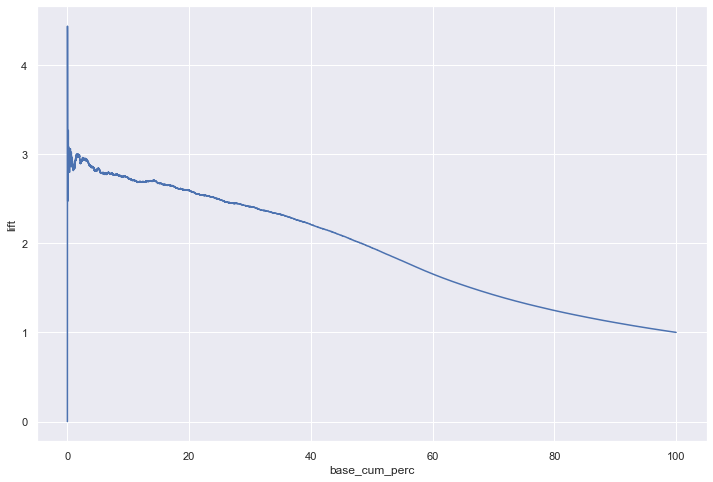

In [158]:
results = pd.DataFrame()
results['prediction'] = yhat_et[:,1].tolist()
results['real'] = y_val.tolist()

# ordering by prediction
results = results.sort_values( 'prediction', ascending=False )

# Percentage of intereset ( Propensity Score )
results['real_cum'] = results['real'].cumsum() 
results['real_cum_perc'] = 100*results['real_cum']/results['real'].sum()

# Percentage of Base ( Clients )
results['base'] = range( 1, len( results ) + 1  )
results['base_cum_perc'] = 100*results['base']/len( results )

# Basline model
results['baseline'] = results['base_cum_perc']

# Lift Calculation
results['lift'] = results['real_cum_perc'] / results['base_cum_perc']

# ROI Curve

plt.figure( figsize=(12,8))
sns.lineplot( x='base_cum_perc', y='lift', data=results )

In [159]:
# Compute bucket
results['bucket'] = results['prediction'].apply( lambda x: 0.9 if x >= 0.90 else 
                                                           0.8 if ( x >= 0.80) & ( x <= 0.90 ) else 
                                                           0.7 if ( x >= 0.70) & ( x <= 0.80 ) else 
                                                           0.6 if ( x >= 0.60) & ( x <= 0.70 ) else 
                                                           0.5 if ( x >= 0.50) & ( x <= 0.60 ) else 
                                                           0.4 if ( x >= 0.40) & ( x <= 0.50 ) else 
                                                           0.3 if ( x >= 0.30) & ( x <= 0.40 ) else 
                                                           0.2 if ( x >= 0.20) & ( x <= 0.30 ) else 
                                                           0.1 if ( x >= 0.10) & ( x <= 0.20 ) else 0.01 )

#  Aggregate clients among buckets
df = results[['prediction','bucket']].groupby( 'bucket' ).agg( {'min', 'count'} ).reset_index()
df.columns = df.columns.droplevel()
df.columns = ['index', 'clients', 'propensity_score']

# Compute revenue and cost
df['gross_revenue'] = 40 * df['clients'] * df['propensity_score'] 
df['cost'] = 4 * df['clients']

df['base'] = df['clients'].sort_values( ascending=True ).cumsum() / df['clients'].sum()

# revenue
df['revenue'] = df['gross_revenue'] - df['cost']
df = df.sort_values( 'index', ascending=False )
df

,index,clients,propensity_score,gross_revenue,cost,base,revenue
9,0.90,0.9,129,4644.0,3.6,1.000000,4640.4
8,0.80,0.8,288,9216.0,3.2,0.800000,9212.8
7,0.70,0.7,573,16044.0,2.8,0.622222,16041.2
6,0.60,0.6,1166,27984.0,2.4,0.466667,27981.6
5,0.50,0.5,1926,38520.0,2.0,0.333333,38518.0
4,0.40,0.4,3364,53824.0,1.6,0.222222,53822.4
3,0.30,0.3,5245,62940.0,1.2,0.133333,62938.8
2,0.20,0.2,6903,55224.0,0.8,0.066667,55223.2
1,0.10,0.1,8265,33060.0,0.4,0.022222,33059.6
0,0.01,0.0,48363,0.0,0.0,0.000000,0.0


# 9.0. DEPLOY MODEL TO PRODUCTION

## 9.1. Insurance Class 

In [41]:
import pickle
import numpy as np
import pandas as pd

class HealthInsurance:
    
    def __init__(self):

        self.home_path                       = 'C:/ProjetosDataScience/20210125_pa004/webapp/parameters'
        self.age_scaler                      = pickle.load(open(self.home_path + 'rescaling_age.pkl','rb'))
        self.annual_premium_scaler           = pickle.load(open(self.home_path + 'rescaling_annual_premium.pkl','rb'))
        self.vintage_scaler                  = pickle.load(open(self.home_path + "rescaling_vintage.pkl",'rb'))
        self.target_encode_gender_scaler     = pickle.load( open( self.home_path + 'target_encode_gender.pkl' ,'rb') )
        self.target_encode_region_code_scaler= pickle.load( open( self.home_path + 'target_encode_region_code.pkl' ,'rb') )
        self.fe_policy_sales_channel_scaler  = pickle.load( open( self.home_path + 'fe_policy_sales_channel.pkl','rb' ) )
              
    def feature_engineering(self, df1):
        #vehicle_age
        df1['vehicle_age'] = df1['vehicle_age'].apply(lambda x:'over_2_years' if x == "> 2 Years" 
                                                  else 'between_1_2_year' if x == '1-2 Years'
                                                  else 'below_1_year')

        #vehicle_damage
        df1['vehicle_damage'] = df1['vehicle_damage'].apply(lambda x: 1 if x == "Yes" else 0)    
        return df1   

    def data_preparation(self, df2):

        df2['age'] = self.age_scaler.fit_transform(df2[['age']])
        df2['annual_premium']= self.annual_premium_scaler.fit_transform(df2[['annual_premium']])
        df2['vintage']= self.vintage_scaler.fit_transform(df2[['vintage']])
        df2.loc[:,'gender']= df2['gender'].map(self.target_encode_gender_scaler)          
        df2.loc[:,'region_code']= df2['region_code'].map(self.target_encode_region_code_scaler)               
        df2.loc[:,'policy_sales_channel']= df2['policy_sales_channel'].map(self.fe_policy_sales_channel_scaler)             
        df2= pd.get_dummies(df2, prefix = 'vehicle_age', columns = ['vehicle_age'])
        cols_selected= ['vintage','annual_premium','age','region_code','vehicle_damage','policy_sales_channel','previously_insured']

        
        return df2[cols_selected]
    
    def get_prediction( self, model, original_data, test_data ):
        # model prediction
        pred = model.predict_proba( test_data )

        # join prediction into original data
        original_data['prediction'] = pred

        return original_data.to_json( orient='records', date_format='iso' )

## 9.2. API Handler 

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response 
from healthinsurance.healthinsurance import HealthInsurance

#loading model
path = 'C:/ProjetosDataScience/20210125_pa004/webapp/model/'
model = pickle.load(open(path + 'model.pkl','rb'))

app = Flask(__name__)

@app.route('healthinsurance/predict', methods = ['POST'])
def health_insurance_predict():
    test_json = request.get_json()
    
    if test_json: # there is data
        if isinstance( test_json, dict ): # unique example
            test_raw = pd.DataFrame( test_json, index=[0] )
            
        else: # multiple example
            test_raw = pd.DataFrame( test_json, columns=test_json[0].keys() )
            
        # Instantiate Rossmann class
        pipeline = HealthInsurance()
        
        # feature engineering
        df1 = pipeline.feature_engineering( test_raw )
        
        # data preparation
        df2 = pipeline.data_preparation( df1 )
        
        # prediction
        df_response = pipeline.get_prediction( model, test_raw, df2 )
        
        return df_response
    
    else:
        return Response( '{}', status=200, mimetype='application/json' )
    
if __name__ == '__main__':
    app.run( '127.0.0.1:500', debug = True )

## 9.3. API Test

In [20]:
test = df1.sample(100)
data = json.dumps(test.to_dict(orient = 'records'))

In [ ]:
#API call
url = 'http://127.0.0.1:5000/healthinsurance/predict'
header = {"Contet-type": 'application/json'}
data = data

#request
r = requests.post(url, data = data, headers = header)
print("Status Code {}".format(r.status_code))

In [ ]:
d1 = pd.DataFrame( r.json(), columns=r.json()[0].keys() )
d1.sort_values( 'score', ascending=False ).head()

In [ ]:
r.json()